# Imports

In [2]:
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine

import numpy as np
import pandas as pd
import geopandas as gpd
from scipy import stats
from itertools import combinations
from typing import Literal

from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import ticker
import seaborn as sns
import zetta_utils as zt 

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'monospace'

# Funções

In [3]:
def kruskal_posthoc(
    df: pd.DataFrame,
    var_categorica: str,
    var_numerica: str,
    alpha: float = 0.05,
    correcao: Literal['bonferroni', 'sidak', 'none'] = 'bonferroni',
    mostrar_plot: bool = True,
    retornar_resultados: bool = False
) -> dict | None:
    """
    Realiza análise estatística comparando grupos de uma variável categórica
    em relação a uma variável numérica.
    
    Usa Kruskal-Wallis (não-paramétrico) + Post-hoc Mann-Whitney U.
    
    Args:
        df: DataFrame com os dados.
        var_categorica: Nome da coluna categórica (grupos).
        var_numerica: Nome da coluna numérica (valores a comparar).
        alpha: Nível de significância (padrão: 0.05).
        correcao: Método de correção para múltiplas comparações.
        mostrar_plot: Se True, exibe boxplot comparativo.
        retornar_resultados: Se True, retorna dicionário com resultados.
    
    Returns:
        Dicionário com resultados (se retornar_resultados=True).
    
    Examples:
        >>> analisar_grupos(df, 'class_tam_imovel', 'indice_jaccard')
        >>> analisar_grupos(df, 'regiao', 'preco', alpha=0.01, correcao='sidak')
        >>> resultados = analisar_grupos(df, 'tipo', 'valor', retornar_resultados=True)
    """
    
    # =========================================================================
    # 1. PREPARAÇÃO DOS DADOS
    # =========================================================================
    
    # Remover NAs
    df_clean = df[[var_categorica, var_numerica]].dropna()
    
    # Identificar grupos únicos
    grupos_nomes = df_clean[var_categorica].unique().tolist()
    n_grupos = len(grupos_nomes)
    
    if n_grupos < 2:
        print("❌ Erro: Necessário pelo menos 2 grupos para comparação.")
        return None
    
    # Separar dados por grupo
    grupos_dados = {
        nome: df_clean[df_clean[var_categorica] == nome][var_numerica].values
        for nome in grupos_nomes
    }
    
    # =========================================================================
    # 2. ESTATÍSTICAS DESCRITIVAS
    # =========================================================================
    
    print("=" * 60)
    print(f"📊 ANÁLISE: {var_numerica.upper()} por {var_categorica.upper()}")
    print("=" * 60)
    
    print("\n📈 ESTATÍSTICAS DESCRITIVAS")
    print("-" * 60)
    
    descritivas = []
    for nome in grupos_nomes:
        dados = grupos_dados[nome]
        desc = {
            'Grupo': nome,
            'N': len(dados),
            'Média': np.mean(dados),
            'Mediana': np.median(dados),
            'Desvio Padrão': np.std(dados),
            'Min': np.min(dados),
            'Max': np.max(dados)
        }
        descritivas.append(desc)
    
    df_desc = pd.DataFrame(descritivas)
    print(df_desc.to_string(index=False))
    
    # =========================================================================
    # 3. TESTE GLOBAL (KRUSKAL-WALLIS)
    # =========================================================================
    
    print("\n🧪 TESTE GLOBAL (Kruskal-Wallis)")
    print("-" * 60)
    
    # Realizar teste
    estatistica_h, p_valor_global = stats.kruskal(*grupos_dados.values())
    
    print(f"H0: As distribuições de '{var_numerica}' são iguais entre os grupos")
    print(f"H1: Pelo menos um grupo difere dos demais")
    print()
    print(f"Estatística H: {estatistica_h:.4f}")
    print(f"P-valor:       {p_valor_global:.2e}")
    print()
    
    if p_valor_global < alpha:
        print(f"✅ REJEITA H0 (p < {alpha})")
        print(f"   Existe diferença estatisticamente significativa entre os grupos.")
        diferenca_global = True
    else:
        print(f"❌ NÃO REJEITA H0 (p >= {alpha})")
        print(f"   Não há evidência de diferença entre os grupos.")
        diferenca_global = False
    
    # =========================================================================
    # 4. TAMANHO DO EFEITO
    # =========================================================================
    
    print("\n📏 TAMANHO DO EFEITO")
    print("-" * 60)
    
    n_total = len(df_clean)
    
    # Epsilon-squared (ε²)
    epsilon2 = (estatistica_h - n_grupos + 1) / (n_total - n_grupos)
    epsilon2 = max(0, epsilon2)  # Garantir não-negativo
    
    # Eta-squared (η²) - alternativa
    eta2 = estatistica_h / (n_total - 1)
    
    # Interpretação
    if epsilon2 < 0.01:
        magnitude = "Desprezível"
        emoji = "⚪"
    elif epsilon2 < 0.06:
        magnitude = "Pequeno"
        emoji = "🟡"
    elif epsilon2 < 0.14:
        magnitude = "Médio"
        emoji = "🟠"
    else:
        magnitude = "Grande"
        emoji = "🔴"
    
    print(f"Epsilon² (ε²): {epsilon2:.4f}")
    print(f"Eta² (η²):     {eta2:.4f}")
    print(f"Magnitude:     {emoji} {magnitude}")
    print()
    print("Referência: < 0.01 Desprezível | 0.01-0.06 Pequeno | 0.06-0.14 Médio | > 0.14 Grande")
    
    # =========================================================================
    # 5. TESTES POST-HOC (PAR A PAR)
    # =========================================================================
    
    print("\n🔬 TESTES POST-HOC (Mann-Whitney U)")
    print("-" * 60)
    
    # Calcular número de comparações
    pares = list(combinations(grupos_nomes, 2))
    n_comparacoes = len(pares)
    
    # Correção para múltiplas comparações
    if correcao == 'bonferroni':
        alpha_corrigido = alpha / n_comparacoes
        print(f"Correção: Bonferroni (α/{n_comparacoes} = {alpha_corrigido:.4f})")
    elif correcao == 'sidak':
        alpha_corrigido = 1 - (1 - alpha) ** (1 / n_comparacoes)
        print(f"Correção: Šídák (α = {alpha_corrigido:.4f})")
    else:
        alpha_corrigido = alpha
        print(f"Sem correção (α = {alpha_corrigido:.4f})")
    
    print()
    
    # Realizar testes par a par
    resultados_posthoc = []
    
    for grupo1, grupo2 in pares:
        dados1 = grupos_dados[grupo1]
        dados2 = grupos_dados[grupo2]
        
        # Mann-Whitney U
        u_stat, p_valor_par = stats.mannwhitneyu(dados1, dados2, alternative='two-sided')
        
        # Tamanho do efeito (r de rank-biserial)
        n1, n2 = len(dados1), len(dados2)
        r_effect = 1 - (2 * u_stat) / (n1 * n2)
        
        # Diferença das medianas
        diff_mediana = np.median(dados1) - np.median(dados2)
        
        significativo = p_valor_par < alpha_corrigido
        
        resultados_posthoc.append({
            'Grupo 1': grupo1,
            'Grupo 2': grupo2,
            'U': u_stat,
            'P-valor': p_valor_par,
            'r (effect)': r_effect,
            'Δ Mediana': diff_mediana,
            'Significativo': significativo
        })
        
        # Print formatado
        sig_str = "✅ SIM" if significativo else "❌ NÃO"
        print(f"{grupo1:15} vs {grupo2:15} | p = {p_valor_par:.2e} | r = {r_effect:+.3f} | {sig_str}")
    
    df_posthoc = pd.DataFrame(resultados_posthoc)
    
    # =========================================================================
    # 6. VISUALIZAÇÃO
    # =========================================================================
    
    if mostrar_plot:
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Boxplot
        ax1 = axes[0]
        sns.boxplot(data=df_clean, x=var_categorica, y=var_numerica, hue=var_categorica, legend=False,
                    palette='viridis', ax=ax1)
        
        # Adicionar médias
        medias = df_clean.groupby(var_categorica)[var_numerica].mean()
        for i, grupo in enumerate(grupos_nomes):
            ax1.scatter(i, medias[grupo], color='red', s=100, zorder=3, marker='D')
        
        ax1.set_title(f'Distribuição de {var_numerica} por {var_categorica}', fontweight='bold')
        ax1.set_xlabel(var_categorica)
        ax1.set_ylabel(var_numerica)
        
        # Violin plot
        ax2 = axes[1]
        sns.violinplot(data=df_clean, x=var_categorica, y=var_numerica, hue=var_categorica, legend=False,
                       palette='viridis', ax=ax2, inner='box')
        ax2.set_title(f'Densidade de {var_numerica} por {var_categorica}', fontweight='bold')
        ax2.set_xlabel(var_categorica)
        ax2.set_ylabel(var_numerica)
        
        plt.tight_layout()
        plt.show()
    
    # =========================================================================
    # 7. RESUMO FINAL
    # =========================================================================
    
    print("\n" + "=" * 60)
    print("📋 RESUMO")
    print("=" * 60)
    
    pares_significativos = df_posthoc[df_posthoc['Significativo']]['Grupo 1'].count()
    
    print(f"• Diferença global: {'SIM' if diferenca_global else 'NÃO'} (p = {p_valor_global:.2e})")
    print(f"• Tamanho do efeito: {magnitude} (ε² = {epsilon2:.4f})")
    print(f"• Pares com diferença significativa: {pares_significativos}/{n_comparacoes}")
    
    if diferenca_global and pares_significativos > 0:
        print("\n📌 Pares significativamente diferentes:")
        for _, row in df_posthoc[df_posthoc['Significativo']].iterrows():
            direcao = ">" if row['Δ Mediana'] > 0 else "<"
            print(f"   • {row['Grupo 1']} {direcao} {row['Grupo 2']} (Δ = {row['Δ Mediana']:.2f})")
    
    # =========================================================================
    # 8. RETORNO
    # =========================================================================
    
    if retornar_resultados:
        return {
            'descritivas': df_desc,
            'teste_global': {
                'estatistica_h': estatistica_h,
                'p_valor': p_valor_global,
                'significativo': diferenca_global
            },
            'tamanho_efeito': {
                'epsilon2': epsilon2,
                'eta2': eta2,
                'magnitude': magnitude
            },
            'posthoc': df_posthoc,
            'config': {
                'alpha': alpha,
                'correcao': correcao,
                'alpha_corrigido': alpha_corrigido
            }
        }

# Configurações

In [5]:
load_dotenv()  # loads .env file

db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_name = os.getenv('DB_NAME')

In [6]:
connection_string = f'postgresql://{db_user}:{db_password}@{db_host}/{db_name}'
engine = create_engine(connection_string)


# Leitura dos dados 

In [8]:
regioes = ['centro_oeste', 'norte', 'nordeste', 'sudeste', 'sul']
dfs = []

sql_template = """
WITH similaridade_imoveis AS (
	SELECT
		DISTINCT ON (s.cod_imovel)
		s.id, s.id_vizinhanca_sigef, s.cod_imovel, di.idt_municipio, di.estado,
		s.tipo_imovel, s.status_imovel, s.data_cadastro_imovel,
		CASE
			WHEN round(di.num_modulo_fiscal::NUMERIC, 4) <= 4::NUMERIC THEN 'Pequeno'
			WHEN round(di.num_modulo_fiscal::NUMERIC, 4) <= 15::NUMERIC THEN 'Médio'
			ELSE 'Grande'
		END AS class_tam_imovel,
		s.area_intersecao_ha, s.area_sicar_ha, s.area_sigef_agregado_ha,
		(dp.cod_cpf_cnpj = sv.cod_cpf_cnpj) AS igualdade_cpf,
		s.indice_jaccard
	FROM cruzamentos.mv_similaridade_sicar_sigef_{regiao} s
	JOIN regularizacao_ambiental.car_imoveis di ON di.cod_imovel = s.cod_imovel
	JOIN regularizacao_ambiental.car_imoveis_proprietarios rip ON rip.idt_imovel = di.idt_imovel
	JOIN regularizacao_ambiental.car_proprietarios dp ON dp.idt_proprietario = rip.idt_proprietario
	JOIN regularizacao_fundiaria.mv_sigef_vizinhanca_{regiao} sv ON sv.id = s.id_vizinhanca_sigef
	WHERE s.tipo_imovel = 'IRU'
	ORDER BY s.cod_imovel, s.indice_jaccard DESC, (CASE WHEN dp.cod_cpf_cnpj = sv.cod_cpf_cnpj THEN 0 ELSE 1 END), s.id_vizinhanca_sigef
),
desmatamento_unico AS (
    SELECT DISTINCT
        cod_imovel,
        ano,
        area_desmat_ha,
        area_imovel_desmat_ha,
        bioma_desmat
    FROM
        analise_dados.mv_imovel_simi_desmat_{regiao}
),
desmatamento_agregado AS (
SELECT
    cod_imovel,
    bioma_desmat,
    COALESCE(SUM(area_imovel_desmat_ha) FILTER (WHERE ano = 2008), 0) AS d2008,
    COALESCE(SUM(area_imovel_desmat_ha) FILTER (WHERE ano = 2009), 0) AS d2009,
    COALESCE(SUM(area_imovel_desmat_ha) FILTER (WHERE ano = 2010), 0) AS d2010,
    COALESCE(SUM(area_imovel_desmat_ha) FILTER (WHERE ano = 2011), 0) AS d2011,
    COALESCE(SUM(area_imovel_desmat_ha) FILTER (WHERE ano = 2012), 0) AS d2012,
    COALESCE(SUM(area_imovel_desmat_ha) FILTER (WHERE ano = 2013), 0) AS d2013,
    COALESCE(SUM(area_imovel_desmat_ha) FILTER (WHERE ano = 2014), 0) AS d2014,
    COALESCE(SUM(area_imovel_desmat_ha) FILTER (WHERE ano = 2015), 0) AS d2015,
    COALESCE(SUM(area_imovel_desmat_ha) FILTER (WHERE ano = 2016), 0) AS d2016,
    COALESCE(SUM(area_imovel_desmat_ha) FILTER (WHERE ano = 2017), 0) AS d2017,
    COALESCE(SUM(area_imovel_desmat_ha) FILTER (WHERE ano = 2018), 0) AS d2018,
    COALESCE(SUM(area_imovel_desmat_ha) FILTER (WHERE ano = 2019), 0) AS d2019,
    COALESCE(SUM(area_imovel_desmat_ha) FILTER (WHERE ano = 2020), 0) AS d2020,
    COALESCE(SUM(area_imovel_desmat_ha) FILTER (WHERE ano = 2021), 0) AS d2021,
    COALESCE(SUM(area_imovel_desmat_ha) FILTER (WHERE ano = 2022), 0) AS d2022,
    COALESCE(SUM(area_imovel_desmat_ha) FILTER (WHERE ano = 2023), 0) AS d2023,
    COALESCE(SUM(area_imovel_desmat_ha) FILTER (WHERE ano = 2024), 0) AS d2024
FROM
    desmatamento_unico
GROUP BY
    cod_imovel, bioma_desmat
)
SELECT 
    si.*,
    '{regiao}' as regiao,
    de.bioma_desmat,
    de.d2008, de.d2009, de.d2010, de.d2011, de.d2012, de.d2013, de.d2014, de.d2015, 
    de.d2016, de.d2017, de.d2018, de.d2019, de.d2020, de.d2021, de.d2022, de.d2023, de.d2024
FROM similaridade_imoveis si
LEFT JOIN desmatamento_agregado de ON de.cod_imovel = si.cod_imovel;
"""

print("Iniciando extração das regiões...")

for regiao in regioes:
    try:
        print(f"Processando: {regiao}...")
        
        query_formatada = sql_template.format(regiao=regiao)
        
        df_temp = pd.read_sql(query_formatada, engine)
        
        if not df_temp.empty:
            dfs.append(df_temp)
            print(f"  -> {len(df_temp)} registros encontrados.")
        else:
            print(f"  -> Nenhum registro encontrado para {regiao}.")
            
    except Exception as e:
        print(f"Erro ao processar {regiao}: {e}")

# Consolida tudo
if dfs:
    df = pd.concat(dfs, ignore_index=True)
    print(f"\nConcluído! Total de registros: {len(df)}")
    df.to_csv('..\dados\similaridade_sicar_sigef_brasil.csv', index=False)
else:
    print("Nenhum dado retornado.")

Iniciando extração das regiões...
Processando: centro_oeste...
  -> 210788 registros encontrados.
Processando: norte...
  -> 262580 registros encontrados.
Processando: nordeste...
  -> 288744 registros encontrados.
Processando: sudeste...
  -> 367804 registros encontrados.
Processando: sul...
  -> 231927 registros encontrados.

Concluído! Total de registros: 1361843


OSError: Cannot save file into a non-existent directory: '..\dados'

In [ ]:
df = pd.read_csv('../dados/similaridade_sicar_sigef_brasil.csv', dtype={'igualdade_cpf': 'boolean'})

In [ ]:
df.head()

,id,id_vizinhanca_sigef,cod_imovel,idt_municipio,estado,tipo_imovel,status_imovel,data_cadastro_imovel,class_tam_imovel,area_intersecao_ha,...,d2015,d2016,d2017,d2018,d2019,d2020,d2021,d2022,d2023,d2024
0,1,4254,DF-5300108-0000AE7221F4458582BE077E36495213,5300108,DF,IRU,AT,2019-05-14 19:30:08.576,Pequeno,9.8434,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,104768,DF-5300108-000246B53E6048558354E03CA022873A,5300108,DF,IRU,AT,2019-12-12 10:53:36.353,Pequeno,7.3658,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,83470,DF-5300108-0012FAB5934B416386711DBD527BD708,5300108,DF,IRU,AT,2025-05-23 08:31:22.331,Grande,160.3013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,21259,DF-5300108-00152EAC5FCF453B845A5097E3336B64,5300108,DF,IRU,AT,2015-07-01 20:23:54.907,Grande,407.8426,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,129143,DF-5300108-001C3919F6B4464C838FFF35E022B147,5300108,DF,IRU,AT,2016-05-02 18:52:52.896,Pequeno,2.0593,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Transformações

### Substuição de valores

In [ ]:
df['regiao'] = df['regiao'].replace({'centro_oeste': 'Centro-Oeste', 'sudeste': 'Sudeste', 'nordeste': 'Nordeste', 'norte': 'Norte', 'sul': 'Sul'})

df['bioma_desmat'] = df['bioma_desmat'].str.capitalize()

### Renomeação de colunas

In [ ]:
df.rename(columns={'estado':'uf'}, inplace=True)

### Transformação para percentual

In [ ]:
df['indice_jaccard'] = df['indice_jaccard']*100

### Converter data para datetime

In [ ]:
df['data_cadastro_imovel'] = pd.to_datetime(df['data_cadastro_imovel'], errors='coerce')
df['ano_cadastro'] = df['data_cadastro_imovel'].dt.year

### Preenchimento de valores nulos

In [ ]:
for ano in range(2008, 2025):
    df[f'd{ano}'] = df[f'd{ano}'].fillna(0)

df['bioma_desmat'] = df['bioma_desmat'].fillna('Sem sobreposição a desmatamento')

### Criação de colunas

In [ ]:
bins = [0, 25, 50, 85, 100.1] 

labels = ["0-25%", "25-50%", "50-85%", "85-100%"]

df["faixa_jaccard"] = pd.cut(
    df["indice_jaccard"], 
    bins=bins, 
    labels=labels, 
    right=False
)

# Desmatamento total por CAR
df['d_total'] = df[[f'd{i}' for i in range(2008, 2025)]].sum(axis=1)

df['geo_ok'] = df['indice_jaccard'] >= 85
df['label_cpf'] = df['igualdade_cpf'].map({True: 'Igual', False: 'Diferente'})
df['label_geo'] = df['geo_ok'].map({True: '>= 85%', False: '< 85%'})



### Ordenação das colunas

In [ ]:
# Ordenar colunas com colunas relacionadas
df = df[[
    'id',
    'id_vizinhanca_sigef',
    'area_sigef_agregado_ha',
    'cod_imovel',
    'area_sicar_ha',
    'area_intersecao_ha',
    'idt_municipio',
    'uf',
    'tipo_imovel',
    'status_imovel',
    'class_tam_imovel',
    'regiao',
    'bioma_desmat',
    'd2008',
    'd2009',
    'd2010',
    'd2011',
    'd2012',
    'd2013',
    'd2014',
    'd2015',
    'd2016',
    'd2017',
    'd2018',
    'd2019',
    'd2020',
    'd2021',
    'd2022',
    'd2023',
    'd2024',
    'd_total',
    'data_cadastro_imovel',
    'ano_cadastro',
    'igualdade_cpf',
    'faixa_jaccard',
    'indice_jaccard'
]]

### Gravação dos dados transformados

In [ ]:
df.to_csv('../dados/similaridade_sicar_sigef_brasil_processado.csv', index=False)

### Leitura dos dados transformados

In [ ]:
df = pd.read_csv('../dados/similaridade_sicar_sigef_brasil_processado.csv', dtype={'igualdade_cpf': 'boolean'})

# EDA

In [ ]:
df.head()

,id,id_vizinhanca_sigef,area_sigef_agregado_ha,cod_imovel,area_sicar_ha,area_intersecao_ha,idt_municipio,uf,tipo_imovel,status_imovel,...,d2024,d_total,data_cadastro_imovel,ano_cadastro,igualdade_cpf,faixa_jaccard,indice_jaccard,geo_ok,label_cpf,label_geo
0,1,4254,9.8438,DF-5300108-0000AE7221F4458582BE077E36495213,9.8438,9.8434,5300108,DF,IRU,AT,...,0.0,0.0000,2019-05-14 19:30:08.576,2019.0,True,85-100%,99.99,True,Igual,>= 85%
1,3,104768,7.3720,DF-5300108-000246B53E6048558354E03CA022873A,7.3661,7.3658,5300108,DF,IRU,AT,...,0.0,0.0000,2019-12-12 10:53:36.353,2019.0,True,85-100%,99.91,True,Igual,>= 85%
2,4,83470,171.6686,DF-5300108-0012FAB5934B416386711DBD527BD708,160.8563,160.3013,5300108,DF,IRU,AT,...,0.0,0.0000,2025-05-23 08:31:22.331,2025.0,False,85-100%,93.08,True,Diferente,>= 85%
3,5,21259,783.8393,DF-5300108-00152EAC5FCF453B845A5097E3336B64,410.0903,407.8426,5300108,DF,IRU,AT,...,0.0,0.4091,2015-07-01 20:23:54.907,2015.0,False,50-85%,51.88,False,Diferente,< 85%
4,6,129143,2.0596,DF-5300108-001C3919F6B4464C838FFF35E022B147,2.0595,2.0593,5300108,DF,IRU,AT,...,0.0,0.0000,2016-05-02 18:52:52.896,2016.0,False,85-100%,99.98,True,Diferente,>= 85%


In [ ]:
def tabela_numericas(df):
    """
    Gera tabela de estatística descritiva para variáveis numéricas
    """
    # Seleciona apenas colunas numéricas
    df_num = df.select_dtypes(include=[np.number])
    
    # Calcula as estatísticas
    stats = pd.DataFrame({
        # 'N': df_num.count(),
        'Média': df_num.mean(),
        'Mediana': df_num.median(),
        'Desvio Padrão': df_num.std(),
        'Mínimo': df_num.min(),
        'Máximo': df_num.max()
        # 'Q1 (25%)': df_num.quantile(0.25),
        # 'Q3 (75%)': df_num.quantile(0.75),
        # 'Amplitude': df_num.max() - df_num.min(),
        # 'IQR': df_num.quantile(0.75) - df_num.quantile(0.25),
        # 'CV (%)': (df_num.std() / df_num.mean() * 100),  # Coef. Variação
        # 'Assimetria': df_num.skew(),
        # 'Curtose': df_num.kurtosis(),
        # 'Missing': df_num.isna().sum(),
        # 'Missing (%)': (df_num.isna().sum() / len(df) * 100)
    })
    
    # Arredonda para 2 casas decimais
    stats = stats.round(2)
    
    return stats


In [ ]:
tabela_numericas(df)

,Média,Mediana,Desvio Padrão,Mínimo,Máximo
id,216531.24,205281.00,138922.04,1.00,582227.00
id_vizinhanca_sigef,139868.90,132876.00,90243.36,1.00,391452.00
area_sigef_agregado_ha,375.20,66.86,5796.88,0.00,4807057.92
area_sicar_ha,271.22,50.39,4928.29,0.01,2750709.35
area_intersecao_ha,203.45,41.31,1422.21,0.00,492405.31
idt_municipio,3176042.68,3143203.00,1243181.62,1100015.00,5300108.00
d2008,2.35,0.00,31.25,0.00,7330.86
d2009,0.19,0.00,6.95,0.00,4390.07
d2010,1.55,0.00,39.65,0.00,20044.50
d2011,0.38,0.00,7.89,0.00,3857.11


In [ ]:
df['ano_cadastro'] = df['ano_cadastro'].astype(str)
tabela_categoricos_expandida(df)

,Variável,Categoria,Frequência,Freq. %
0,cod_imovel,1358932 valores possíveis,Moda: 'AL-2700805-F7DAD155694E4D66B3C7E162AA37...,0.00
1,uf,27 valores possíveis,Moda: 'MG': 224778,16.51
2,tipo_imovel,IRU,1361843,100.00
3,status_imovel,AT,1252732,91.99
4,,PE,99716,7.32
5,,SU,9395,0.69
6,class_tam_imovel,Pequeno,1046458,76.84
7,,Médio,225087,16.53
8,,Grande,90298,6.63
9,regiao,Sudeste,367804,27.01


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1361843.0,2.165312e+05,1.389220e+05,1.000000e+00,1.007905e+05,2.052810e+05,3.122740e+05,5.822270e+05
id_vizinhanca_sigef,1361843.0,1.398689e+05,9.024336e+04,1.000000e+00,6.519600e+04,1.328760e+05,2.021580e+05,3.914520e+05
area_sigef_agregado_ha,1361843.0,3.752023e+02,5.796878e+03,1.700000e-03,2.248160e+01,6.686100e+01,2.153894e+02,4.807058e+06
area_sicar_ha,1361843.0,2.712242e+02,4.928291e+03,8.300000e-03,1.794690e+01,5.038820e+01,1.507135e+02,2.750709e+06
area_intersecao_ha,1361843.0,2.034485e+02,1.422213e+03,1.700000e-03,1.220650e+01,4.130660e+01,1.279245e+02,4.924053e+05
idt_municipio,1361843.0,3.176043e+06,1.243182e+06,1.100015e+06,2.110005e+06,3.143203e+06,4.201604e+06,5.300108e+06
d2008,1361843.0,2.351024e+00,3.125417e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.330856e+03
d2009,1361843.0,1.899033e-01,6.946174e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.390069e+03
d2010,1361843.0,1.554421e+00,3.964778e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.004450e+04
d2011,1361843.0,3.752984e-01,7.892538e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.857107e+03


## 1. Panorama Regional e Operacional


In [ ]:
# Total de observações
print(f'Total de observações: {df.shape[0]}')

Total de observações: 1361843


### Similaridade e Titularidade por UF

In [ ]:
df['uf'].value_counts(normalize=True)*100

uf
MG    16.505427
SP     8.813277
PA     7.933440
MA     7.506005
PR     7.116679
GO     6.689758
MT     5.628108
SC     5.155954
RS     4.757744
RO     4.752604
BA     4.478343
MS     2.899894
TO     2.821471
PI     2.422673
CE     1.912482
PB     1.837290
AM     1.708861
PE     1.190519
ES     1.080594
RR     0.817275
AC     0.814411
SE     0.741201
RN     0.717851
RJ     0.608514
AP     0.433163
AL     0.396081
DF     0.260382
Name: proportion, dtype: float64

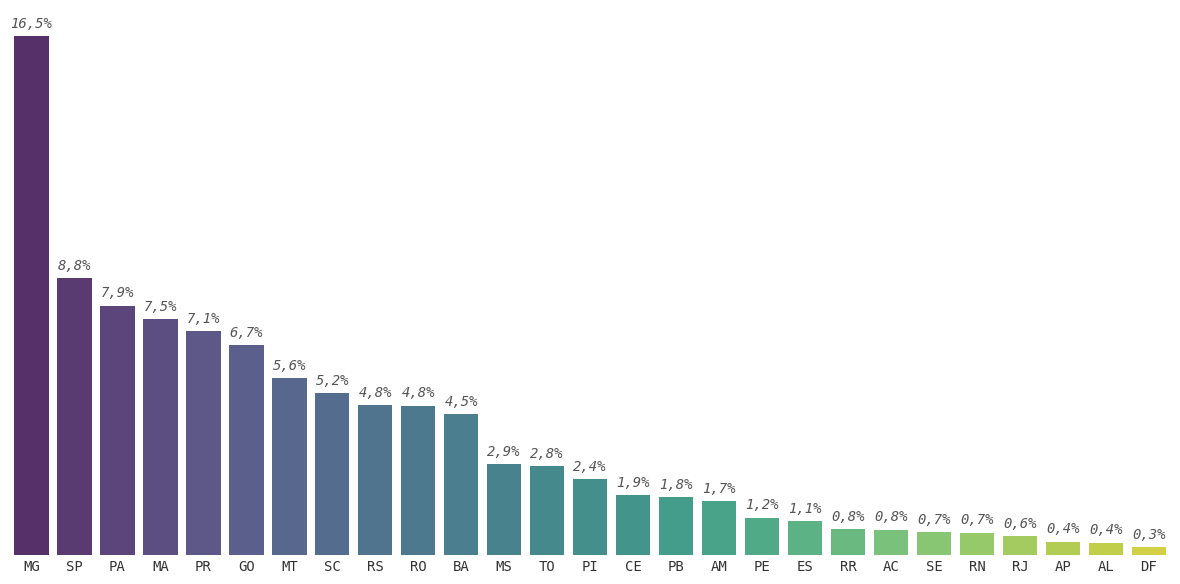

In [ ]:
zt.bar_plot(df, 'uf', percentage=True, figsize=(12, 6), )

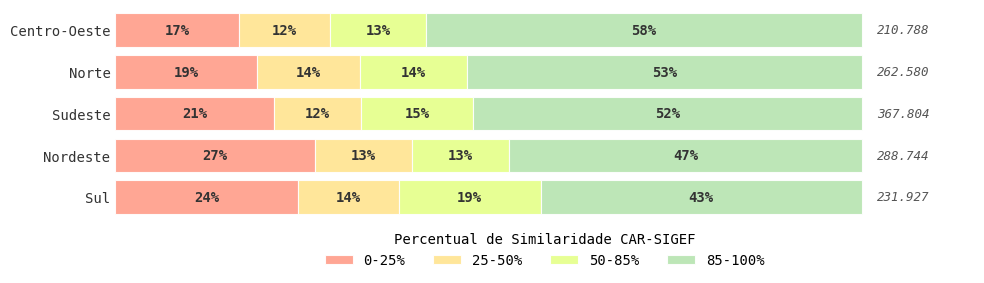

In [ ]:
zt.stacked_bar_plot(
    df,
    y="regiao",
    hue="faixa_jaccard",
    order_hue=["0-25%", "25-50%", "50-85%", "85-100%"],
    palette=[ '#FF9D89', '#FFE48F', "#E5FF89",  '#B6E4B0'],
    legend_title="Percentual de Similaridade CAR-SIGEF",
    use_suffix=False,
    figsize=(10, 3)
)

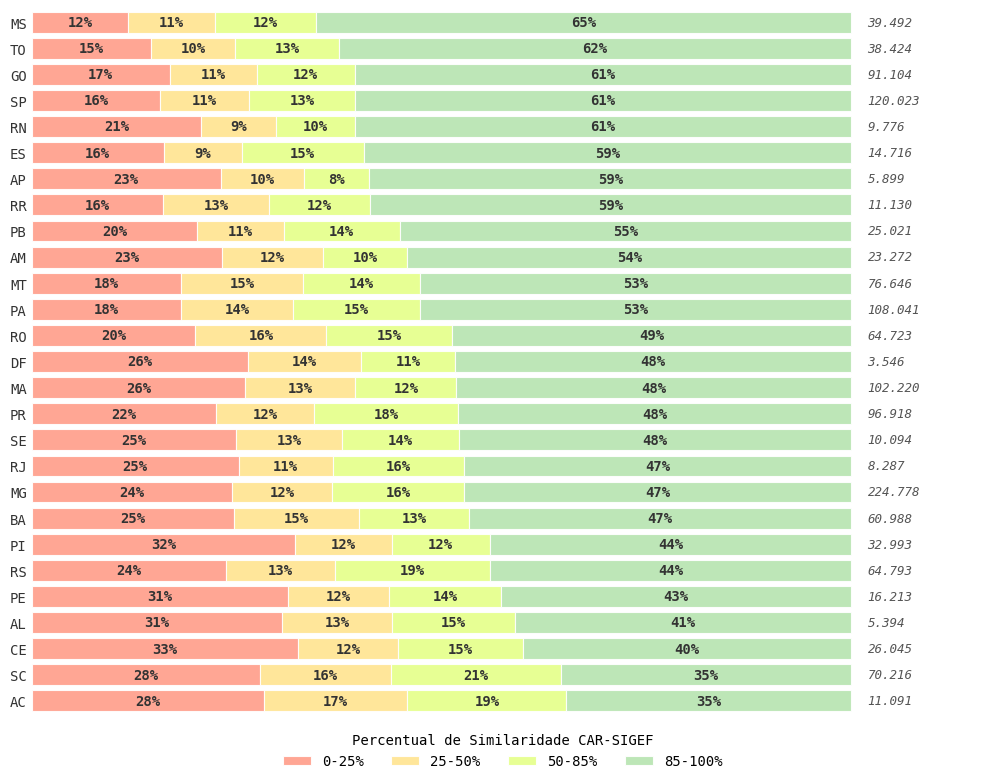

In [ ]:
zt.stacked_bar_plot(
    df,
    y="uf",
    hue="faixa_jaccard",
    order_hue=["0-25%", "25-50%", "50-85%", "85-100%"],
    palette=[ '#FF9D89', '#FFE48F', "#E5FF89",  '#B6E4B0'],
    legend_title="Percentual de Similaridade CAR-SIGEF",
    use_suffix=False,
    figsize=(10, 8)
)

### Titularidade por UF

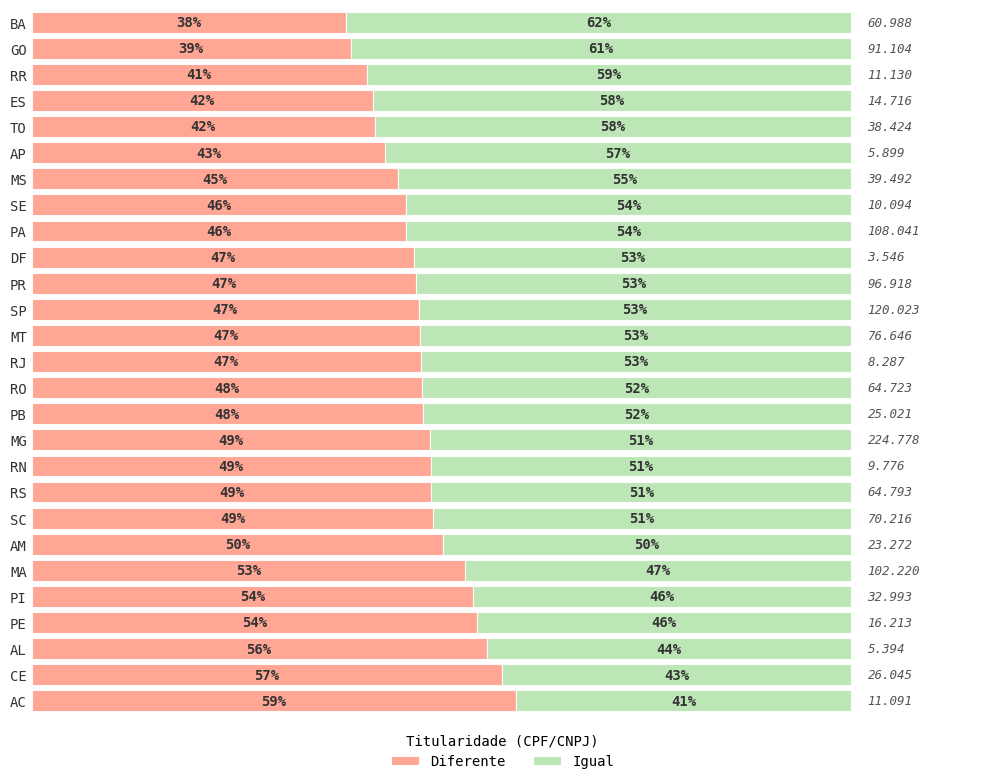

In [ ]:
zt.stacked_bar_plot(
    df,
    y="uf",
    hue="label_cpf",
    order_hue=["Diferente", "Igual"],
    palette=[ '#FF9D89', '#B6E4B0'],
    legend_title="Titularidade (CPF/CNPJ)",
    use_suffix=False,
    figsize=(10, 8)
)

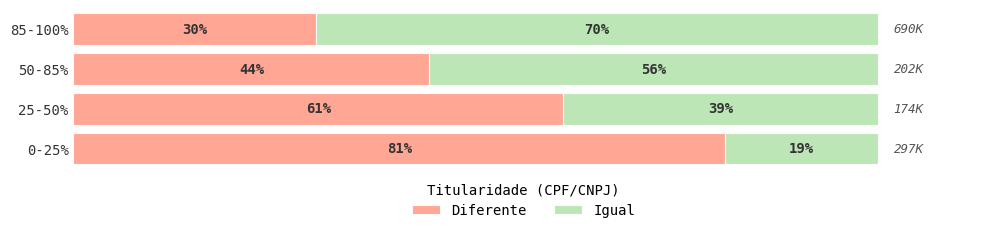

In [ ]:
zt.stacked_bar_plot(
    df,
    'faixa_jaccard',
    'label_cpf',
    order_hue=["Diferente", "Igual"],
    palette=[ '#FF9D89', '#B6E4B0'],
    legend_title="Titularidade (CPF/CNPJ)",
    figsize=(10, 2.5)
    )

### Classe de Tamanho vs Similaridade

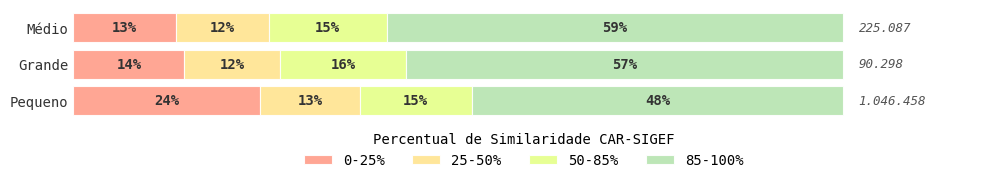

In [ ]:
zt.stacked_bar_plot(
    df,
    y="class_tam_imovel",
    hue="faixa_jaccard",
    order_hue=["0-25%", "25-50%", "50-85%", "85-100%"],
    palette=[ '#FF9D89', '#FFE48F', "#E5FF89",  '#B6E4B0'],
    legend_title="Percentual de Similaridade CAR-SIGEF",
    use_suffix=False,
    figsize=(10, 2)
)

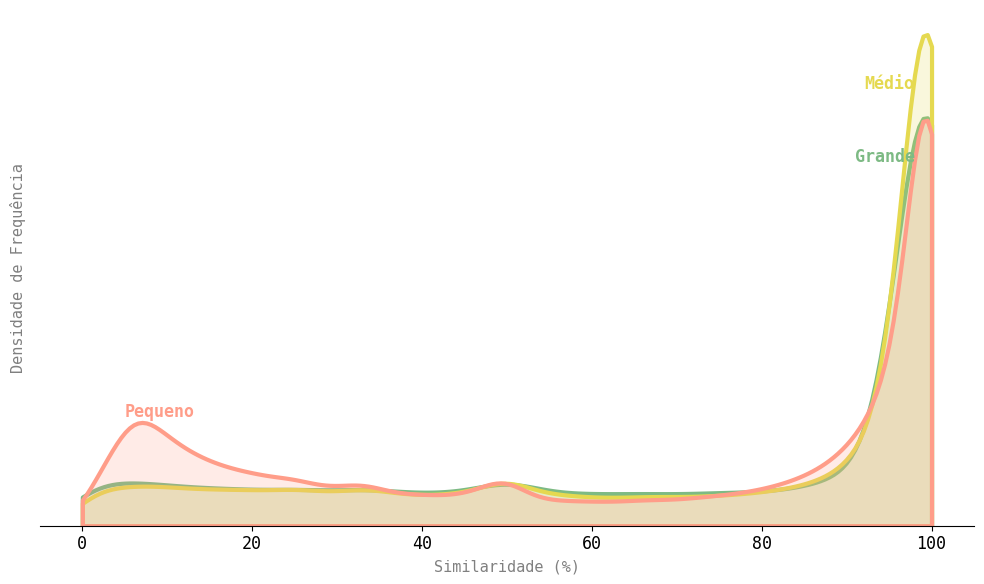

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração do tamanho
plt.figure(figsize=(10, 6))

# Cores
cores = {"Pequeno": "#FF9D89", "Médio": "#E5D950", "Grande": "#7DBA84"}

# Plotagem
ax = sns.kdeplot(
    data=df,
    x="indice_jaccard",
    hue="class_tam_imovel",
    hue_order=["Pequeno", "Médio", "Grande"],
    fill=True,
    common_norm=False,
    alpha=0.2,
    linewidth=3,
    palette=list(cores.values()),
    clip=(0, 100),
    legend=False 
)

# --- AQUI ESTÁ A SOLUÇÃO HÍBRIDA ---

# 1. REMOVER OS NÚMEROS (TICKS)
plt.yticks([]) 

# 2. ADICIONAR O RÓTULO DESCRITIVO
# labelpad afasta um pouco o texto do gráfico para respirar
plt.ylabel("Densidade de Frequência", fontsize=11, color="grey", labelpad=10)

# 3. LIMPEZA VISUAL (Remover a linha vertical preta)
# Como tiramos os números, a linha vertical não precisa existir. O texto basta.
sns.despine(left=True, top=True, right=True)

# -----------------------------------

plt.xlabel("Similaridade (%)", fontsize=11, color="grey")

# ROTULAGEM DIRETA (Ajuste os valores de X e Y conforme seus dados reais)
# Dica: Usei fontweight='bold' para dar peso de legenda
plt.text(x=5, y=0.015, s="Pequeno", color=cores["Pequeno"], fontsize=12, fontweight='bold')

# Ajustei o alinhamento (ha='right') para o texto terminar no pico
plt.text(x=98, y=0.060, s="Médio", color=cores["Médio"], fontsize=12, fontweight='bold', ha='right')
plt.text(x=98, y=0.050, s="Grande", color=cores["Grande"], fontsize=12, fontweight='bold', ha='right')

plt.tight_layout()
plt.show()

In [ ]:
kruskal_posthoc(df, var_categorica='class_tam_imovel', var_numerica='indice_jaccard', mostrar_plot=False, retornar_resultados=False)

📊 ANÁLISE: INDICE_JACCARD por CLASS_TAM_IMOVEL

📈 ESTATÍSTICAS DESCRITIVAS
------------------------------------------------------------
  Grupo       N     Média  Mediana  Desvio Padrão  Min   Max
Pequeno 1046458 64.430556    82.16      36.548787  0.0 100.0
 Grande   90298 73.053887    94.43      33.291689  0.0 100.0
  Médio  225087 74.570083    95.11      32.445240  0.0 100.0

🧪 TESTE GLOBAL (Kruskal-Wallis)
------------------------------------------------------------
H0: As distribuições de 'indice_jaccard' são iguais entre os grupos
H1: Pelo menos um grupo difere dos demais

Estatística H: 21192.9116
P-valor:       0.00e+00

✅ REJEITA H0 (p < 0.05)
   Existe diferença estatisticamente significativa entre os grupos.

📏 TAMANHO DO EFEITO
------------------------------------------------------------
Epsilon² (ε²): 0.0156
Eta² (η²):     0.0156
Magnitude:     🟡 Pequeno

Referência: < 0.01 Desprezível | 0.01-0.06 Pequeno | 0.06-0.14 Médio | > 0.14 Grande

🔬 TESTES POST-HOC (Mann-Whitney U)

In [ ]:
df['status_imovel'].value_counts(normalize=True)*100

status_imovel
AT    91.987990
PE     7.322136
SU     0.689874
Name: proportion, dtype: float64

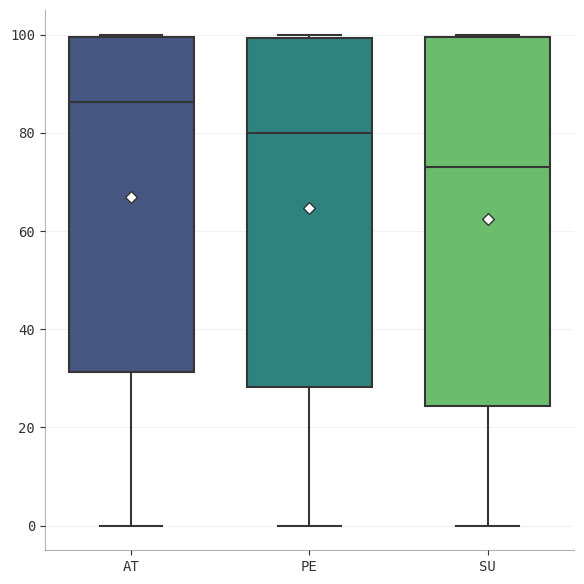

In [ ]:
zt.box_plot(df, y='indice_jaccard', x='status_imovel', figsize=(6,6))

In [ ]:
sns.boxplot(df, 'class_tam_imovel')

TypeError: boxplot() takes from 0 to 1 positional arguments but 2 were given

### Status vs Similaridade

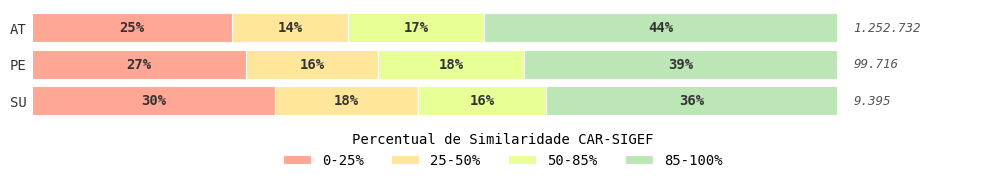

In [ ]:
zt.stacked_bar_plot(
    df,
    y="status_imovel",
    hue="faixa_jaccard",
    order_hue=["0-25%", "25-50%", "50-85%", "85-100%"],
    palette=[ '#FF9D89', '#FFE48F', "#E5FF89",  '#B6E4B0'],
    legend_title="Percentual de Similaridade CAR-SIGEF",
    use_suffix=False,
    figsize=(10, 2)
)

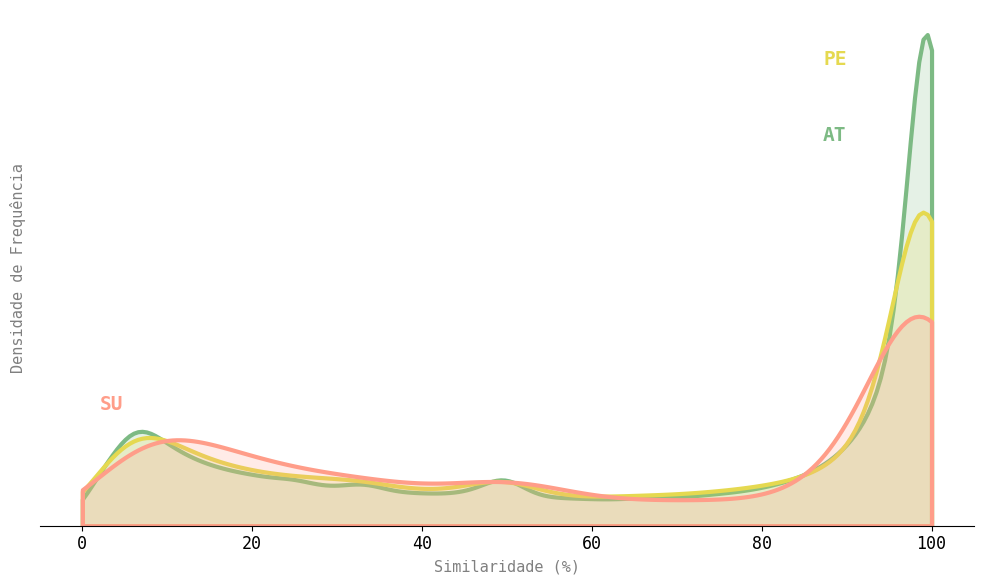

In [ ]:
# Configuração do tamanho
plt.figure(figsize=(10, 6))

# Cores (Definindo em variáveis para usar no texto depois)
cores = {"SU": "#FF9D89", "PE": "#E5D950", "AT": "#7DBA84"}

# Plotagem
ax = sns.kdeplot(
    data=df,
    x="indice_jaccard",
    hue="status_imovel",
    hue_order=["SU", "PE", "AT"],
    fill=True,
    common_norm=False,
    alpha=0.2,
    linewidth=3, # Linha um pouco mais grossa para destaque
    palette=list(cores.values()),
    clip=(0, 100),
    legend=False # DESLIGAR a legenda automática
)

# 1. REMOVER O EIXO Y (Princípio: Eliminar a bagunça)
# A altura exata não importa, apenas a comparação entre as curvas.
plt.yticks([])

plt.xlabel("Similaridade (%)", fontsize=11, color="grey")

# 2. ADICIONAR O RÓTULO DESCRITIVO
# labelpad afasta um pouco o texto do gráfico para respirar
plt.ylabel("Densidade de Frequência", fontsize=11, color="grey", labelpad=10)

# 3. LIMPEZA VISUAL (Remover a linha vertical preta)
# Como tiramos os números, a linha vertical não precisa existir. O texto basta.
sns.despine(left=True, top=True, right=True)


# 3. ROTULAGEM DIRETA (Princípio: Aproximar os dados da legenda)
# Em vez de uma caixa de legenda, escrevemos o nome da categoria na cor da linha.
# Ajuste as coordenadas (x, y) manualmente conforme o pico das suas curvas.
# Baseado na sua imagem, os picos estão em 100, então vou colocar os textos alinhados lá ou perto.

# Exemplo de posicionamento (você pode precisar ajustar levemente os valores X e Y)
plt.text(x=2, y=0.015, s="SU", color=cores["SU"], fontsize=14, fontweight='bold')
plt.text(x=90, y=0.060, s="PE", color=cores["PE"], fontsize=14, fontweight='bold', ha='right')
plt.text(x=90, y=0.050, s="AT", color=cores["AT"], fontsize=14, fontweight='bold', ha='right')


# Ajuste para garantir que o título não seja cortado
plt.tight_layout()
plt.show()

In [ ]:
kruskal_posthoc(df, 'status_imovel', 'indice_jaccard', mostrar_plot=False)

📊 ANÁLISE: INDICE_JACCARD por STATUS_IMOVEL

📈 ESTATÍSTICAS DESCRITIVAS
------------------------------------------------------------
Grupo       N     Média  Mediana  Desvio Padrão  Min   Max
   AT 1252732 66.874561   86.370      35.894477 0.00 100.0
   PE   99716 64.609948   79.975      36.180241 0.00 100.0
   SU    9395 62.448027   73.070      36.720635 0.04 100.0

🧪 TESTE GLOBAL (Kruskal-Wallis)
------------------------------------------------------------
H0: As distribuições de 'indice_jaccard' são iguais entre os grupos
H1: Pelo menos um grupo difere dos demais

Estatística H: 241.5268
P-valor:       3.57e-53

✅ REJEITA H0 (p < 0.05)
   Existe diferença estatisticamente significativa entre os grupos.

📏 TAMANHO DO EFEITO
------------------------------------------------------------
Epsilon² (ε²): 0.0002
Eta² (η²):     0.0002
Magnitude:     ⚪ Desprezível

Referência: < 0.01 Desprezível | 0.01-0.06 Pequeno | 0.06-0.14 Médio | > 0.14 Grande

🔬 TESTES POST-HOC (Mann-Whitney U)
--------

In [ ]:
kruskal_posthoc(df[df['d_total'] != 0 ], 'faixa_jaccard', 'd_total', mostrar_plot=False)

📊 ANÁLISE: D_TOTAL por FAIXA_JACCARD

📈 ESTATÍSTICAS DESCRITIVAS
------------------------------------------------------------
  Grupo      N     Média  Mediana  Desvio Padrão    Min        Max
 50-85%  86475 47.106744   6.4863     349.019788 0.0001 53803.8054
85-100% 296855 36.941672   6.5942     200.967553 0.0001 43541.1433
 25-50%  74063 50.595282   6.6552     348.807887 0.0001 35729.9901
  0-25% 118641 38.523088   4.1277     343.881554 0.0001 41109.4325

🧪 TESTE GLOBAL (Kruskal-Wallis)
------------------------------------------------------------
H0: As distribuições de 'd_total' são iguais entre os grupos
H1: Pelo menos um grupo difere dos demais

Estatística H: 3681.6426
P-valor:       0.00e+00

✅ REJEITA H0 (p < 0.05)
   Existe diferença estatisticamente significativa entre os grupos.

📏 TAMANHO DO EFEITO
------------------------------------------------------------
Epsilon² (ε²): 0.0064
Eta² (η²):     0.0064
Magnitude:     ⚪ Desprezível

Referência: < 0.01 Desprezível | 0.01-0.06 

## 2.  Evolução da Similaridade

In [ ]:
# =============================================================================
# FUNÇÃO 1: LINHA ÚNICA (Atualizada com Eixo Y Opcional)
# =============================================================================

def plot_evolucao_swd(
    df: pd.DataFrame,
    x: str,
    y: str,
    agg: Literal['mean', 'median', 'sum'] = 'median',
    title: str = "",
    subtitle: str = "",
    color: str = "#2563eb",
    figsize: tuple[float, float] = (12, 6),
    line_width: float = 3,
    show_trend: bool = False,
    label_mode: Literal['all', 'end', 'both', 'none'] = 'both',
    # NOVO ARGUMENTO:
    show_y_axis: bool = False, 
    y_format: Literal['number', 'percent', 'currency'] = 'number',
    date_format: str | None = None,
    ax: plt.Axes | None = None,
) -> plt.Axes:
    
    # 1. PREPARAÇÃO
    dados = df.groupby(x)[y].agg(agg).reset_index().sort_values(x)
    x_vals = dados[x]
    y_vals = dados[y]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    # 2. PLOTAGEM
    if show_trend:
        x_numeric = np.arange(len(x_vals))
        z = np.polyfit(x_numeric, y_vals, 1)
        p = np.poly1d(z)
        ax.plot(x_vals, p(x_numeric), color='grey', linestyle='--', alpha=0.4, lw=1, zorder=1)

    ax.plot(x_vals, y_vals, color=color, linewidth=line_width, zorder=2)
    
    def fmt_val(val):
        return f"{val:.0f}%" if y_format == 'percent' else f"{val:.1f}"

    # Lógica de Labels (Pontos e Textos)
    if label_mode == 'all':
        ax.scatter(x_vals, y_vals, color=color, s=40, zorder=3, edgecolors='white', linewidths=1.5)
        for xv, yv in zip(x_vals, y_vals):
            ax.annotate(fmt_val(yv), (xv, yv), xytext=(0, 10), textcoords='offset points',
                        color=color, fontsize=9, fontweight='bold', ha='center', va='bottom')
            
    else:
        start_x, start_y = x_vals.iloc[0], y_vals.iloc[0]
        end_x, end_y = x_vals.iloc[-1], y_vals.iloc[-1]

        if label_mode == 'both':
            ax.scatter(start_x, start_y, color=color, s=60, zorder=3, edgecolors='white', linewidths=1.5)
            ax.annotate(fmt_val(start_y), (start_x, start_y), xytext=(-8, 0), textcoords='offset points',
                        color=color, fontsize=10, fontweight='bold', ha='right', va='center')

        if label_mode in ['end', 'both']:
            ax.scatter(end_x, end_y, color=color, s=60, zorder=3, edgecolors='white', linewidths=1.5)
            ax.annotate(fmt_val(end_y), (end_x, end_y), xytext=(8, 0), textcoords='offset points',
                        color=color, fontsize=11, fontweight='bold', ha='left', va='center')

    # 3. ESTILO E EIXOS (Aqui entra a lógica do Eixo Y)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('#cccccc')
    
    # Grid Vertical (Tempo)
    ax.xaxis.grid(True, linestyle='--', alpha=0.3, color='#e0e0e0')

    if show_y_axis:
        # Mostra eixo Y Minimalista
        ax.spines['left'].set_visible(False) # Remove a linha vertical, mantém os números
        ax.tick_params(axis='y', colors='grey', labelsize=9, length=0) # Sem "tracinhos" (ticks)
        ax.yaxis.grid(True, linestyle='-', alpha=0.2, color='#e0e0e0') # Grid horizontal ajuda a ler
        
        # Formatação do Eixo Y
        if y_format == 'percent':
            ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{x:.0f}%"))
        elif y_format == 'currency':
            ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"R${x:,.0f}"))
    else:
        # Remove completamente
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.set_ylabel('')
    
    # Eixo X
    if date_format:
        ax.xaxis.set_major_formatter(mdates.DateFormatter(date_format))
    ax.tick_params(axis='x', colors='grey', labelsize=10)
    ax.set_xlabel('')
    
    # 4. CONTROLE DE MARGEM
    if pd.api.types.is_datetime64_any_dtype(x_vals):
        min_date, max_date = x_vals.min(), x_vals.max()
        margin = (max_date - min_date) * 0.15 
        ax.set_xlim(right=max_date + margin)

    # Títulos
    if title:
        ax.text(x=0, y=1.12, s=title, transform=ax.transAxes, fontsize=16, fontweight='bold', color='#333333', ha='left')
    if subtitle:
        ax.text(x=0, y=1.06, s=subtitle, transform=ax.transAxes, fontsize=11, color='grey', ha='left')

    plt.tight_layout()
    return ax


# =============================================================================
# FUNÇÃO 2: MULTI-LINHAS (Atualizada com Eixo Y Opcional)
# =============================================================================

def _ajustar_posicoes_texto(posicoes, min_dist=3.0):
    """Função auxiliar para evitar sobreposição de texto no eixo Y."""
    ordenado = sorted(posicoes, key=lambda k: k['y'], reverse=True)
    if len(ordenado) < 2: return ordenado

    for i in range(1, len(ordenado)):
        anterior = ordenado[i-1]
        atual = ordenado[i]
        dist = anterior['y_ajustado'] - atual['y']
        
        if dist < min_dist:
            novo_y = anterior['y_ajustado'] - min_dist
            atual['y_ajustado'] = novo_y
        else:
            atual['y_ajustado'] = atual['y']
    return ordenado

def plot_evolucao_multi_swd(
    df: pd.DataFrame,
    x: str,
    y: str,
    hue: str,
    agg: Literal['mean', 'median', 'sum'] = 'median',
    title: str = "",
    subtitle: str = "",
    highlights: list[str] | None = None,
    gray_color: str = "#e0e0e0",
    label_mode: Literal['end', 'both'] = 'end',
    # NOVO ARGUMENTO:
    show_y_axis: bool = False,
    palette: dict | str = "viridis", 
    figsize: tuple[float, float] = (12, 6),
    line_width: float = 2.5,
    y_format: Literal['number', 'percent'] = 'number',
    date_format: str | None = None,
    collision_spacing: float = 3.0,
    ax: plt.Axes | None = None,
) -> plt.Axes:
    
    dados = df.groupby([x, hue])[y].agg(agg).reset_index()
    grupos = dados[hue].unique()
    
    if isinstance(palette, dict):
        color_map = palette
    else:
        cmap = plt.get_cmap(palette)
        cols = cmap(np.linspace(0.2, 0.8, len(grupos)))
        color_map = {g: c for g, c in zip(grupos, cols)}

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    final_labels_data = []
    
    # PLOTAGEM
    for grupo in grupos:
        subset = dados[dados[hue] == grupo].sort_values(x)
        is_highlighted = (highlights is None) or (grupo in highlights)
        
        cor = color_map.get(grupo, "#333333") if is_highlighted else gray_color
        lw = (line_width + 1) if (highlights and is_highlighted) else (1.5 if highlights else line_width)
        alpha = 1.0 if is_highlighted else 0.7
        z_order = 5 if is_highlighted else 1
        font_weight = 'bold' if is_highlighted else 'normal'

        ax.plot(subset[x], subset[y], color=cor, linewidth=lw, alpha=alpha, zorder=z_order)
        
        start_x, start_y = subset[x].iloc[0], subset[y].iloc[0]
        end_x, end_y = subset[x].iloc[-1], subset[y].iloc[-1]
        
        def fmt(val): return f"{val:.0f}%" if y_format == 'percent' else f"{val:.1f}"

        if label_mode == 'both':
            ax.scatter(start_x, start_y, color=cor, s=40, zorder=z_order, edgecolors='white')
            ax.annotate(fmt(start_y), (start_x, start_y), xytext=(-8, 0), textcoords='offset points',
                        color=cor, fontsize=10, fontweight=font_weight, ha='right', va='center')

        s_size = 50 if is_highlighted else 20
        ax.scatter(end_x, end_y, color=cor, s=s_size, zorder=z_order, edgecolors='white')

        label_text = f" {grupo} {fmt(end_y)}" if is_highlighted else f" {grupo}"
        final_labels_data.append({
            'y': end_y, 'y_ajustado': end_y, 'x': end_x,
            'text': label_text, 'color': cor,
            'fontsize': 11 if is_highlighted else 9, 'weight': font_weight
        })

    # ANTI-COLISÃO
    final_labels_data = _ajustar_posicoes_texto(final_labels_data, min_dist=collision_spacing)
    for item in final_labels_data:
        ax.annotate(item['text'], xy=(item['x'], item['y_ajustado']), xytext=(8, 0), 
                    textcoords='offset points', color=item['color'], fontsize=item['fontsize'], 
                    fontweight=item['weight'], ha='left', va='center')

    # ESTILO E EIXOS (Lógica Eixo Y)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('#cccccc')
    
    # Grid Vertical
    ax.xaxis.grid(True, linestyle='--', alpha=0.5, color='#b0b0b0')
    
    if show_y_axis:
        ax.spines['left'].set_visible(False) # Sem linha vertical preta
        ax.tick_params(axis='y', colors='grey', labelsize=12, length=0) 
        ax.yaxis.grid(True, linestyle='-', alpha=0.4, color='#b0b0b0') # Grid horizontal suave
        
        if y_format == 'percent':
            ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{x:.0f}%"))
        elif y_format == 'currency':
            ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"R${x:,.0f}"))
    else:
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.set_ylabel('')

    if date_format:
        ax.xaxis.set_major_formatter(mdates.DateFormatter(date_format))
    ax.tick_params(axis='x', colors='grey', labelsize=12)    
    ax.set_xlabel('')

    # CONTROLE DE MARGEM
    if pd.api.types.is_datetime64_any_dtype(dados[x]):
        min_date, max_date = dados[x].min(), dados[x].max()
        margin = (max_date - min_date) * 0.15 
        ax.set_xlim(right=max_date + margin)

    if title:
        ax.text(x=0, y=1.12, s=title, transform=ax.transAxes, fontsize=16, fontweight='bold', color='#333333', ha='left')
    if subtitle:
        ax.text(x=0, y=1.06, s=subtitle, transform=ax.transAxes, fontsize=11, color='grey', ha='left')

    plt.tight_layout()
    return ax

In [ ]:
consulta = """
SELECT 
    EXTRACT(YEAR FROM ci.dat_criacao) AS ano,
    count(*) as total
FROM regularizacao_ambiental.car_imoveis ci 
GROUP BY 
    EXTRACT(YEAR FROM ci.dat_criacao)
ORDER BY 
    ano DESC;
"""


df_total_car_por_ano = pd.read_sql(consulta, engine).dropna()
df_total_car_por_ano['ano'] = df_total_car_por_ano['ano'].astype(str).str[:4]

df['ano_cadastro_str'] = df['ano_cadastro'].dropna().astype(str).str[:4]

# Seu agrupamento original
car_com_similaridade = df.groupby('ano_cadastro_str').size()

# Transformando em DataFrame
df_car_com_similaridade = car_com_similaridade.reset_index(name='total_car_com_similaridade')
df_final = pd.merge(
    df_total_car_por_ano,           
    df_car_com_similaridade,                  
    left_on='ano',             
    right_on='ano_cadastro_str', 
    how='outer'                
)

df_final['total'] = df_final['total'].astype(int)
df_final['total_car_com_similaridade'] = df_final['total_car_com_similaridade'].astype(int)

# 2. Calcular o percentual (evitando divisão por zero)
df_final['pct_similaridade'] = df_final.apply(
    lambda x: (x['total_car_com_similaridade'] / x['total'] * 100) if x['total'] > 0 else 0, 
    axis=1
)

# 3. Ordenação para o gráfico (Geralmente decrescente pelo Total)
df_plot = df_final.sort_values('total', ascending=False) # Ascending true para o horizontal ficar de cima pra 

In [7]:
# Buscar total de CARs cadastrados por ano (sem filtro de similaridade)
consulta_total_cars = """
SELECT 
    EXTRACT(YEAR FROM ci.dat_criacao) AS ano,
    count(*) as total_cars_cadastrados
FROM regularizacao_ambiental.car_imoveis ci 
GROUP BY EXTRACT(YEAR FROM ci.dat_criacao)
ORDER BY ano;
"""

df_total_car_por_ano = pd.read_sql(consulta_total_cars, engine).dropna()
df_total_car_por_ano['ano'] = df_total_car_por_ano['ano'].astype(int)
df_total_car_por_ano

,ano,total_cars_cadastrados
0,2014,96315
1,2015,675306
2,2016,1212663
3,2017,602175
4,2018,558461
5,2019,809113
6,2020,546567
7,2021,579279
8,2022,620464
9,2023,738765


In [10]:
# Criar coluna ano_cadastro a partir de data_cadastro_imovel
df['ano_cadastro'] = pd.to_datetime(df['data_cadastro_imovel']).dt.year

# Adicionar coluna de total de CARs cadastrados ao dataframe principal
df = df.merge(
    df_total_car_por_ano,
    left_on='ano_cadastro',
    right_on='ano',
    how='left'
)

# Remover coluna 'ano' duplicada
df = df.drop(columns=['ano'])

# Verificar se a coluna foi adicionada
print(f"Colunas após merge: {list(df.columns)[-5:]}")  # Mostrar últimas 5 colunas
print(f"\nTotal de registros: {len(df):,}")
print(f"\nExemplo de dados:")
df[['ano_cadastro', 'total_cars_cadastrados']].head()

Colunas após merge: ['d2022', 'd2023', 'd2024', 'ano_cadastro', 'total_cars_cadastrados']

Total de registros: 1,361,843

Exemplo de dados:


,ano_cadastro,total_cars_cadastrados
0,2019.0,809113.0
1,2019.0,809113.0
2,2025.0,764948.0
3,2015.0,675306.0
4,2016.0,1212663.0


In [12]:
# Salvar CSV atualizado com a coluna de total de CARs cadastrados
import os
csv_path = 'data/similaridade_sicar_sigef_brasil.csv'

# Criar diretório se não existir
os.makedirs('data', exist_ok=True)

# Salvar CSV
df.to_csv(csv_path, index=False)
print(f"✅ CSV atualizado salvo em: {csv_path}")
print(f"📊 Total de registros: {len(df):,}")
print(f"📊 Total de colunas: {len(df.columns)}")
print(f"✨ Nova coluna adicionada: total_cars_cadastrados")

✅ CSV atualizado salvo em: data/similaridade_sicar_sigef_brasil.csv
📊 Total de registros: 1,361,843
📊 Total de colunas: 35
✨ Nova coluna adicionada: total_cars_cadastrados


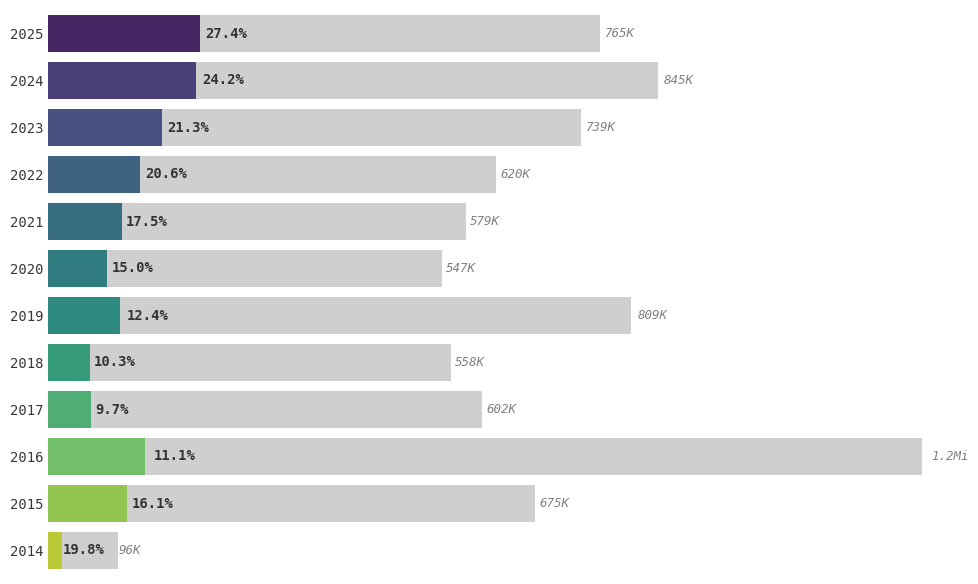

In [ ]:
# Função de formatação (mantida igual)
def format_k(value):
    if value >= 1_000_000:
        return f'{value/1_000_000:.1f}Mi'
    if value >= 1_000:
        return f'{value/1_000:.0f}K'
    return str(value)

# 1. ORDENAÇÃO
# Para ficar igual à imagem (maior total no topo), ordenamos decrescente
df_plot = df_final.sort_values('ano', ascending=False)

fig, ax = plt.subplots(figsize=(10,6 ))

# --- CAMADA 1: O TOTAL (Barra de Fundo) ---
# Mudamos para um cinza bem claro (Light Gray) para igualar a referência
sns.barplot(
    data=df_plot,
    y='ano',
    x='total',
    color='#cfcfcf',  # Cinza claro igual à imagem de referência
    alpha=1.0,        # Opacidade total pois a cor já é clara
    ax=ax,
    orient='h'
)

# --- CAMADA 2: A SIMILARIDADE (Barra de Frente) ---
sns.barplot(
    data=df_plot,
    y='ano',
    x='total_car_com_similaridade',
    hue='ano',        # Necessário para a paleta funcionar corretamente
    palette='viridis',
    dodge=False,      # Garante que a barra fique sobreposta, não ao lado
    ax=ax,
    orient='h'
)

# Remove a legenda automática que o hue cria
if ax.get_legend():
    ax.legend_.remove()

# --- RÓTULOS ---
for i in range(len(df_plot)):
    row = df_plot.iloc[i]
    total = row['total']
    parcial = row['total_car_com_similaridade']
    pct = row['pct_similaridade']
    
    # 1. Texto do Percentual (Escuro, Bold)
    ax.text(
        x=parcial + (total * 0.01), 
        y=i, 
        s=f'{pct:.1f}%', 
        va='center', 
        fontsize=10, 
        fontweight='bold', 
        color='#333333' # Cinza quase preto
    )

    # 2. Texto do Total Geral (Cinza, Itálico)
    ax.text(
        x=total + (total * 0.01), 
        y=i, 
        s=format_k(total), 
        va='center', 
        fontsize=9, 
        style='italic',
        color='gray'
    )

# --- ESTILIZAÇÃO DO EIXO Y (AQUI ESTÁ O SEU PEDIDO) ---
# labelcolor='gray': deixa o texto cinza
# labelsize=11: diminui um pouco a fonte
# length=0: remove os tracinhos (ticks) que ficam à esquerda da barra
ax.tick_params(axis='y', labelcolor="#383838", labelsize=10, length=0)

# Limpeza geral
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([]) # Remove eixo X
sns.despine(left=True, bottom=True) # Remove bordas

plt.tight_layout()
plt.show()

In [ ]:
df_car_com_simi_por_ano = df.groupby(['ano_cadastro']).size().reset_index()
df_car_com_simi_por_ano['ano_cadastro'] = df_car_com_simi_por_ano['ano_cadastro'].astype(str).str[:4]
df_car_com_simi_por_ano.columns = ['ano_cadastro', 'total']

In [ ]:
df_total_car_por_ano

,ano,total
1,2025,764948
2,2024,845444
3,2023,738765
4,2022,620464
5,2021,579279
6,2020,546567
7,2019,809113
8,2018,558461
9,2017,602175
10,2016,1212663


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Literal

def plot_evolucao_combo(
    df: pd.DataFrame,
    x: str,
    y: str,
    # Dados para barras
    df_bars: pd.DataFrame | None = None,
    x_bars: str | None = None,
    y_bars: str | None = None,           # Barra principal (ou interna)
    y_bars_total: str | None = None,     # Barra de fundo (total)
    # Agregação
    agg: Literal['mean', 'median', 'sum'] = 'median',
    # Visual
    title: str = "",
    subtitle: str = "",
    color_line: str = "#2563eb",
    color_bars: str = "#2563eb",
    color_bars_total: str = "#e0e0e0",
    figsize: tuple[float, float] = (12, 6),
    line_width: float = 3,
    bar_width: float = 0.6,
    bar_alpha: float = 0.7,
    bar_total_alpha: float = 0.3,
    # Labels
    show_trend: bool = False,
    label_mode: Literal['all', 'end', 'both', 'none'] = 'both',
    show_bar_labels: bool = True,
    show_bar_total_labels: bool = True,
    # Formatos
    y_format: Literal['number', 'percent', 'currency'] = 'number',
    y2_format: Literal['number', 'percent', 'currency'] = 'number',
    # Legenda
    show_legend: bool = True,
    legend_line_label: str = "Métrica",
    legend_bar_label: str = "Parcial",
    legend_bar_total_label: str = "Total",
    date_format: str | None = None,
    ax: plt.Axes | None = None,

    # ===== NOVO: controle de escala =====
    ylim_line: tuple[float | None, float | None] | None = None,
    ylim_bars: tuple[float | None, float | None] | None = None,
    yscale_line: Literal['linear', 'log', 'symlog'] = 'linear',
    yscale_bars: Literal['linear', 'log', 'symlog'] = 'linear',
) -> plt.Axes:
    """
    Plota gráfico combinado: barras sobrepostas (total vs parte) + linha (métrica).

    NOVO:
      - ylim_line: (min, max) do eixo da linha (ax)
      - ylim_bars: (min, max) do eixo das barras (ax2)
      - yscale_line / yscale_bars: 'linear' | 'log' | 'symlog'
    """

    # =========================================================================
    # 1. PREPARAÇÃO DOS DADOS
    # =========================================================================

    dados_linha = df.groupby(x)[y].agg(agg).reset_index().sort_values(x)
    x_vals = dados_linha[x]
    y_vals = dados_linha[y]

    if df_bars is not None:
        x_bars = x_bars or x
        dados_barras = df_bars.sort_values(x_bars)
        x_bars_vals = dados_barras[x_bars]
        y_bars_vals = dados_barras[y_bars]

        if y_bars_total is not None:
            y_bars_total_vals = dados_barras[y_bars_total]

    # =========================================================================
    # 2. CRIAR FIGURA
    # =========================================================================

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    # Escala do eixo da linha (mesmo com ticks escondidos, afeta o desenho)
    ax.set_yscale(yscale_line)

    # =========================================================================
    # 3. PLOTAR BARRAS
    # =========================================================================

    ax2 = None
    if df_bars is not None:
        ax2 = ax.twinx()
        ax2.set_yscale(yscale_bars)

        x_positions = np.arange(len(x_bars_vals))

        # Determinar limite Y automático das barras (se o usuário não passar ylim_bars)
        if y_bars_total is not None:
            max_bar_val = np.nanmax(y_bars_total_vals.to_numpy())
        else:
            max_bar_val = np.nanmax(y_bars_vals.to_numpy())

        # BARRA DE FUNDO (TOTAL)
        if y_bars_total is not None:
            bars_total = ax2.bar(
                x_positions,
                y_bars_total_vals,
                width=bar_width,
                color=color_bars_total,
                alpha=bar_total_alpha,
                zorder=1,
                edgecolor='white',
                linewidth=0.5
            )

            if show_bar_total_labels:
                for bar, val in zip(bars_total, y_bars_total_vals):
                    height = bar.get_height()
                    label = format_value(val, y2_format)
                    ax2.annotate(
                        label,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=8, color='#888888'
                    )

        # BARRA DA FRENTE (PARCIAL)
        bars = ax2.bar(
            x_positions,
            y_bars_vals,
            width=bar_width,
            color=color_bars,
            alpha=bar_alpha,
            zorder=2,
            edgecolor='white',
            linewidth=0.5
        )

        if show_bar_labels:
            for bar, val in zip(bars, y_bars_vals):
                height = bar.get_height()
                label = format_value(val, y2_format)

                if y_bars_total is not None:
                    ax2.annotate(
                        label,
                        xy=(bar.get_x() + bar.get_width() / 2, height / 2),
                        ha='center', va='center',
                        fontsize=8, fontweight='bold', color='white'
                    )
                else:
                    ax2.annotate(
                        label,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=8, color='#888888'
                    )

        # Remover eixos Y (visual)
        ax2.set_yticks([])
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.tick_params(axis='y', left=False, right=False)

        # ===== NOVO: aplicar escala das barras =====
        if ylim_bars is not None:
            ax2.set_ylim(ylim_bars)
        else:
            # mantém seu padrão (um "respiro" acima do maior valor)
            ax2.set_ylim(0, max_bar_val * 1.3)

    # =========================================================================
    # 4. PLOTAR LINHA
    # =========================================================================

    if df_bars is not None:
        x_plot = x_positions
    else:
        x_plot = x_vals

    if show_trend:
        x_numeric = np.arange(len(x_vals))
        z = np.polyfit(x_numeric, y_vals, 1)
        p = np.poly1d(z)
        ax.plot(x_plot, p(x_numeric), color='grey', linestyle='--', alpha=0.4, lw=1, zorder=3)

    ax.plot(x_plot, y_vals, color=color_line, linewidth=line_width, zorder=4)

    # ===== NOVO: aplicar escala da linha =====
    if ylim_line is not None:
        ax.set_ylim(ylim_line)

    def fmt_val(val):
        if y_format == 'percent':
            return f"{val:.0f}%"
        elif y_format == 'currency':
            return f"R${val:,.0f}"
        return f"{val:.1f}"

    if label_mode == 'all':
        ax.scatter(x_plot, y_vals, color=color_line, s=50, zorder=5, edgecolors='white', linewidths=2)
        for xv, yv in zip(x_plot, y_vals):
            ax.annotate(
                fmt_val(yv), (xv, yv),
                xytext=(0, 12), textcoords='offset points',
                color=color_line, fontsize=10, fontweight='bold', ha='center', va='bottom'
            )
    else:
        if label_mode in ['both', 'start']:
            start_x = x_plot.iloc[0] if hasattr(x_plot, 'iloc') else x_plot[0]
            ax.scatter(start_x, y_vals.iloc[0], color=color_line, s=60, zorder=5, edgecolors='white', linewidths=2)
            ax.annotate(
                fmt_val(y_vals.iloc[0]),
                (start_x, y_vals.iloc[0]),
                xytext=(-10, 0), textcoords='offset points',
                color=color_line, fontsize=11, fontweight='bold', ha='right', va='center'
            )

        if label_mode in ['both', 'end']:
            end_x = x_plot.iloc[-1] if hasattr(x_plot, 'iloc') else x_plot[-1]
            ax.scatter(end_x, y_vals.iloc[-1], color=color_line, s=60, zorder=5, edgecolors='white', linewidths=2)
            ax.annotate(
                fmt_val(y_vals.iloc[-1]),
                (end_x, y_vals.iloc[-1]),
                xytext=(10, 0), textcoords='offset points',
                color=color_line, fontsize=11, fontweight='bold', ha='left', va='center'
            )

    # =========================================================================
    # 5. ESTILO
    # =========================================================================

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#cccccc')

    ax.set_yticks([])
    ax.tick_params(axis='y', left=False, labelleft=False)

    if df_bars is not None:
        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_bars_vals, fontsize=10)

    ax.tick_params(axis='x', colors='grey', labelsize=10)
    ax.set_xlabel('')

    ax.xaxis.grid(True, linestyle='--', alpha=0.3, color='#e0e0e0')

    if df_bars is not None:
        ax.set_xlim(-0.5, len(x_positions) - 0.5)

    # =========================================================================
    # 6. LEGENDA
    # =========================================================================

    if show_legend and df_bars is not None:
        from matplotlib.lines import Line2D
        from matplotlib.patches import Patch

        legend_elements = [
            Line2D([0], [0], color=color_line, linewidth=line_width, label=legend_line_label),
            Patch(facecolor=color_bars, alpha=bar_alpha, edgecolor='white', label=legend_bar_label),
        ]

        if y_bars_total is not None:
            legend_elements.append(
                Patch(facecolor=color_bars_total, alpha=bar_total_alpha, edgecolor='white', label=legend_bar_total_label)
            )

        ax.legend(
            handles=legend_elements,
            loc='upper center',
            bbox_to_anchor=(0.5, -0.08),
            ncol=3 if y_bars_total else 2,
            frameon=False,
            fontsize=10,
            columnspacing=3,
            handletextpad=0.8
        )

    # =========================================================================
    # 7. TÍTULOS
    # =========================================================================

    if title:
        ax.text(x=0, y=1.12, s=title, transform=ax.transAxes,
                fontsize=16, fontweight='bold', color='#333333', ha='left')
    if subtitle:
        ax.text(x=0, y=1.06, s=subtitle, transform=ax.transAxes,
                fontsize=11, color='grey', ha='left')

    plt.tight_layout()
    return ax


def format_value(val, fmt):
    if fmt == 'percent':
        return f"{val:.0f}%"
    elif fmt == 'currency':
        if val >= 1_000_000:
            return f"R${val/1_000_000:.1f}M"
        elif val >= 1_000:
            return f"R${val/1_000:.0f}K"
        return f"R${val:.0f}"
    else:
        if val >= 1_000_000:
            return f"{val/1_000_000:.1f}M"
        elif val >= 1_000:
            return f"{val/1_000:.0f}K"
        return f"{val:.0f}"

<Axes: >

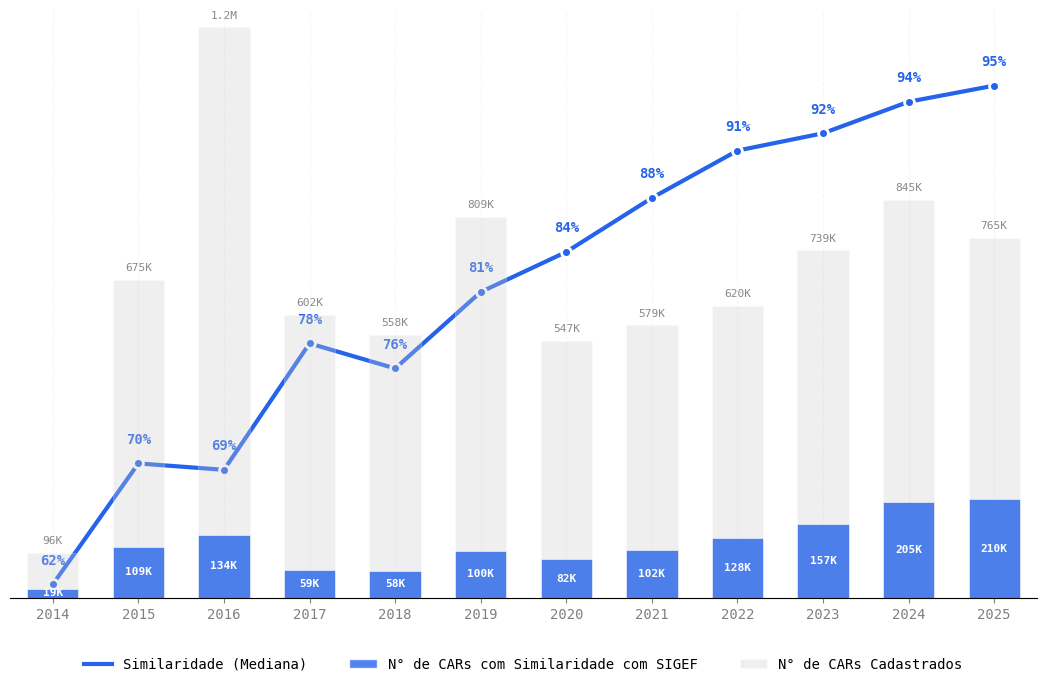

In [ ]:
# 1. Consolidar DataFrames
df_bars = df_total_car_por_ano.merge(
    df_car_com_simi_por_ano,
    left_on='ano', 
    right_on='ano_cadastro', 
    how='left',
    suffixes=('_total', '_simi')
).fillna(0)

plot_evolucao_combo(
    df=df, 
    x='ano_cadastro', 
    y='indice_jaccard',
    agg='median',

    df_bars=df_bars,
    x_bars='ano_cadastro',
    y_bars='total_simi',
    y_bars_total='total_total',

    color_line='#2563eb',
    color_bars='#2563eb',
    color_bars_total='#cccccc',
    bar_alpha=0.8,
    bar_total_alpha=0.3,

    label_mode='all',
    show_bar_labels=True,
    show_bar_total_labels=True,

    y_format='percent',
    y2_format='number',

    legend_line_label='Similaridade (Mediana)',
    legend_bar_label='N° de CARs com Similaridade com SIGEF',
    legend_bar_total_label='N° de CARs Cadastrados',

    figsize=(11, 7),

    # ===== NOVO: escalas =====
    ylim_line=(61, 100),         # linha em % (0 a 100)
    ylim_bars=(0, 1250000),      # ajuste para seu volume de CARs
)

In [ ]:
# Consolidar em um único DataFrame
df_bars_consolidado = df_total_car_por_ano.merge(
    df_car_com_simi_por_ano, 
    left_on='ano', 
    right_on='ano_cadastro',
    how='left',
    suffixes=('_total', '_simi')
).rename(columns={
    'total_total': 'total_cars',
    'total_simi': 'cars_com_similaridade'
})

# Preencher NaN com 0 se houver
df_bars_consolidado = df_bars_consolidado.fillna(0)

<Axes: >

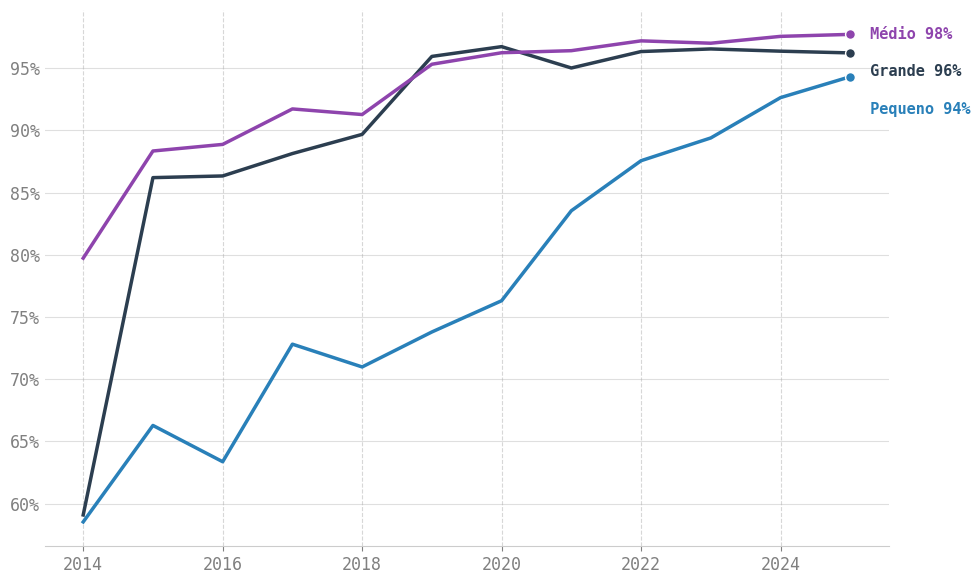

In [ ]:
cores_tamanho = {"Pequeno": "#2980b9", "Médio":"#8e44ad", "Grande": "#2c3e50"}

plot_evolucao_multi_swd(
    df, x='ano_cadastro', y='indice_jaccard', hue='class_tam_imovel',
    agg='median',
    palette=cores_tamanho,
    y_format='percent',
    figsize=(10,6),
    label_mode='ends',
    show_y_axis=True
)

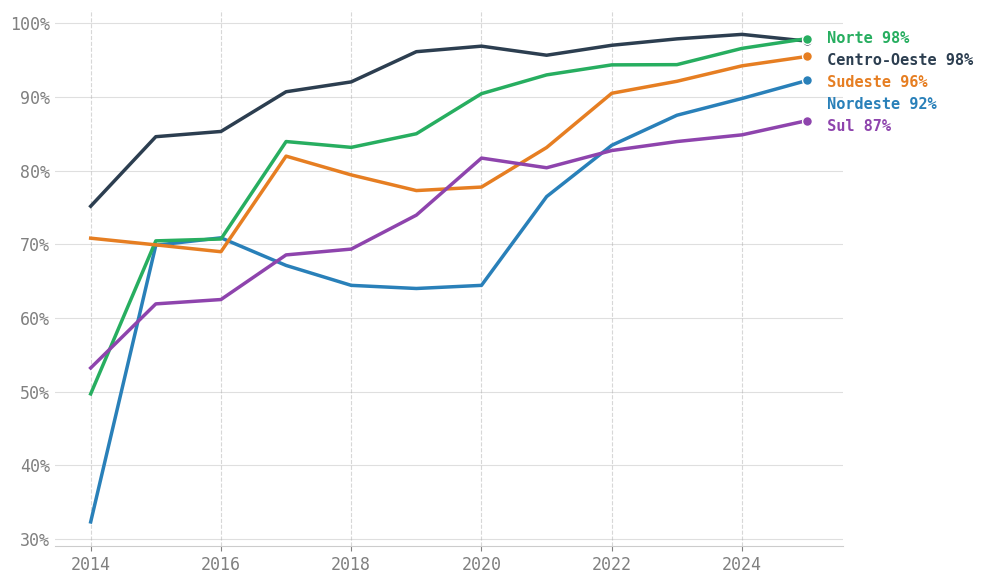

In [ ]:
# 1. Defina suas cores de destaque
cores_regiao = {
    "Centro-Oeste": "#2c3e50", # Azul escuro
    "Nordeste":     "#2980b9", # Azul vibrante
    "Norte":        "#27ae60", # Verde
    "Sudeste":      "#e67e22", # Laranja
    "Sul":          "#8e44ad"  # Roxo
}

# 2. Chame a função
plot_evolucao_multi_swd(
    df, 
    x='ano_cadastro', 
    y='indice_jaccard', 
    hue='regiao',
    agg='median',                   
    y_format="percent",
    palette=cores_regiao,
    label_mode='ends',
    show_y_axis=True,
    figsize=(10,6),  
)

plt.show()

## 3. Diagnóstico de Similaridade Espacial

### Histograma

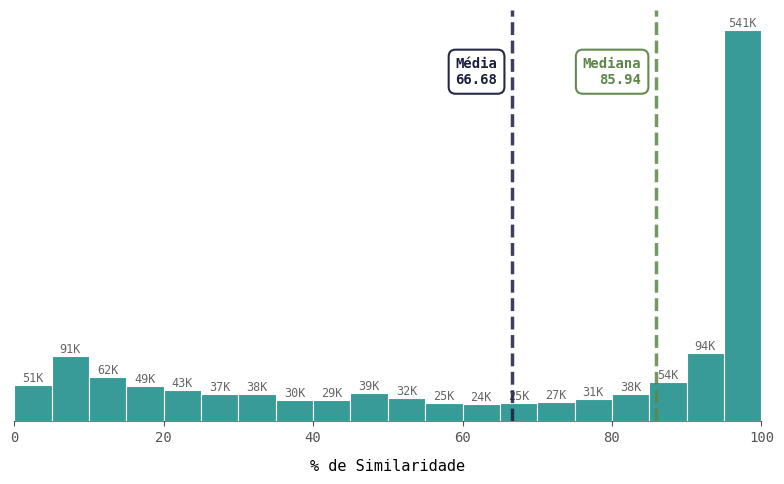

In [ ]:
zt.hist_plot(df, 'indice_jaccard', xlabel='% de Similaridade', decimal_places=2, figsize=(8, 5))

In [ ]:
df['indice_jaccard'].describe()

count    1.361843e+06
mean     6.667821e+01
std      3.592782e+01
min      0.000000e+00
25%      3.092000e+01
50%      8.594000e+01
75%      9.943000e+01
max      1.000000e+02
Name: indice_jaccard, dtype: float64

### Distribuição por faixa

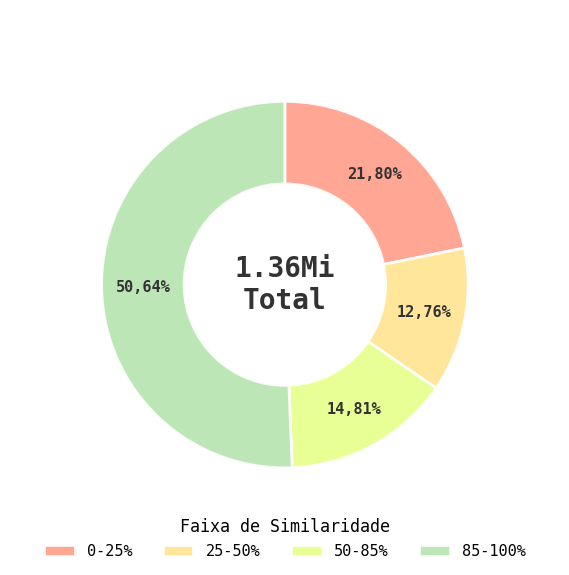

In [ ]:
zt.donut_plot(df, 'faixa_jaccard', 
              figsize=(8, 6), 
              decimal_places=2,
              legend_style='simple',
              legend_loc='bottom',
              legend_frameon=False,
              order=['0-25%', '25-50%', '50-85%', '85-100%'],
              label_colors='#333333',
              palette=[ '#FF9D89', '#FFE48F', "#E5FF89",  '#B6E4B0'],
              legend_title='Faixa de Similaridade')

- 50,6% dos casos de similaridade, 85% ou mais de similaridade

### Análise de Áreas

In [ ]:
df['descrepancia'] = ((df['area_sicar_ha'] - df['area_sigef_agregado_ha']) / df['area_sigef_agregado_ha']) * 100

bins = [-np.inf, -10, -1, 1, 10, np.inf]
labels = [
    'Car < Sigef\n(> -10%)',
    'Car < Sigef\n(-1% a -10%)', 
    'Exato\n(± 1%)',          
    'Car > Sigef\n(+1% a +10%)', 
    'Car > Sigef\n(> +10%)'
]

df['faixa_diff'] = pd.cut(df['descrepancia'], bins=bins, labels=labels)

cores = {
    labels[0]: '#95a5a6',
    labels[1]: '#bdc3c7',
    labels[2]: '#27ae60',
    labels[3]: '#f39c12',
    labels[4]: '#c0392b'
}

In [ ]:
# Definindo limites de tolerância (Ex: +/- 10% é aceitável?)
# Ajuste conforme a legislação ou regra de negócio (INCRA costuma usar 5% ou 10% dependendo do caso)
limite_aceitavel = 10 

def categorizar_erro(v):
    if -limite_aceitavel <= v <= limite_aceitavel:
        return 'Preciso'
    elif v > limite_aceitavel:
        return 'Superestimado (CAR > SIGEF)' # Tentativa de grilagem ou erro de soma?
    else: # v < -limite_aceitavel
        return 'Subestimado (CAR < SIGEF)'   # Esqueceu de declarar área?

df['status_area'] = df['descrepancia'].apply(categorizar_erro)

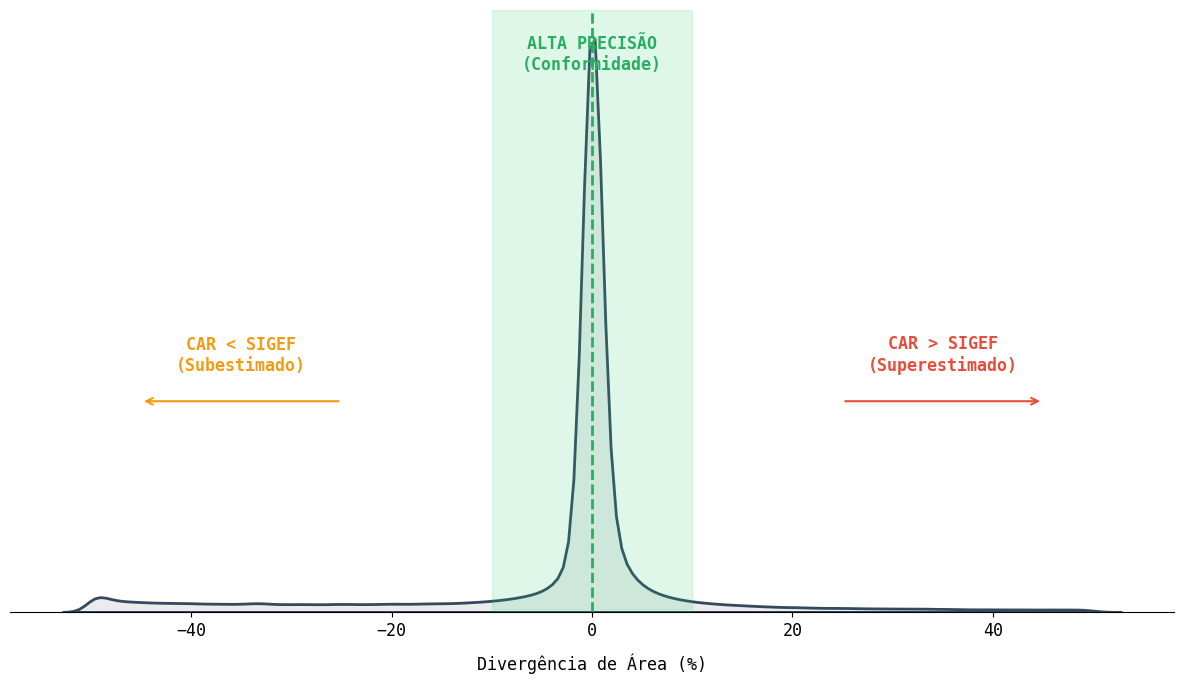

In [ ]:

# 1. Filtro (Garanta que não está vazio)
filtro_visual = df[(df['descrepancia'] >= -50) & (df['descrepancia'] <= 50)]

if filtro_visual.empty:
    print("Aviso: Nenhum dado encontrado no intervalo de -50% a 50%.")
else:
    plt.figure(figsize=(12, 7))

    # Plot
    ax = sns.kdeplot(
        data=filtro_visual, 
        x='descrepancia', 
        fill=True, 
        color="#34495e", 
        alpha=0.1,
        linewidth=2
    )

    # --- CORREÇÃO AQUI ---
    # Em vez de tentar achar a linha, pegamos o limite superior do eixo Y
    # Isso funciona sempre, independente de como o seaborn desenhou o gráfico.
    ymax = ax.get_ylim()[1] 

    # --- STORYTELLING ---

    # 1. Zona de Precisão (Verde)
    plt.axvspan(-10, 10, color='#2ecc71', alpha=0.15, label='Zona de Precisão')
    # Posiciona o texto em 90% da altura total
    plt.text(0, ymax * 0.90, 'ALTA PRECISÃO\n(Conformidade)', ha='center', color='#27ae60', fontweight='bold')

    # 2. Linha do Zero
    plt.axvline(0, color='#27ae60', linestyle='--', linewidth=2)

    # 3. Zona de Superestimação (Texto posicionado proporcionalmente)
    plt.text(35, ymax * 0.4, 'CAR > SIGEF\n(Superestimado)', ha='center', color='#e74c3c', fontweight='bold')
    
    # Seta indicativa
    ax.annotate('', xy=(45, ymax*0.35), xytext=(25, ymax*0.35),
                arrowprops=dict(arrowstyle="->", color='#e74c3c', lw=1.5))

    # 4. Zona de Subestimação
    plt.text(-35, ymax * 0.4, 'CAR < SIGEF\n(Subestimado)', ha='center', color='#f39c12', fontweight='bold')
    
    # Seta indicativa
    ax.annotate('', xy=(-45, ymax*0.35), xytext=(-25, ymax*0.35),
                arrowprops=dict(arrowstyle="->", color='#f39c12', lw=1.5))

    # --- VISUAL ---
    sns.despine(left=True)
    plt.yticks([]) 
    plt.xlabel('Divergência de Área (%)', fontsize=12, labelpad=10)
    plt.ylabel('')
    

    plt.tight_layout()
    plt.show()

## 5. Matriz de Confiabilidade: Espaço vs. Titularidade

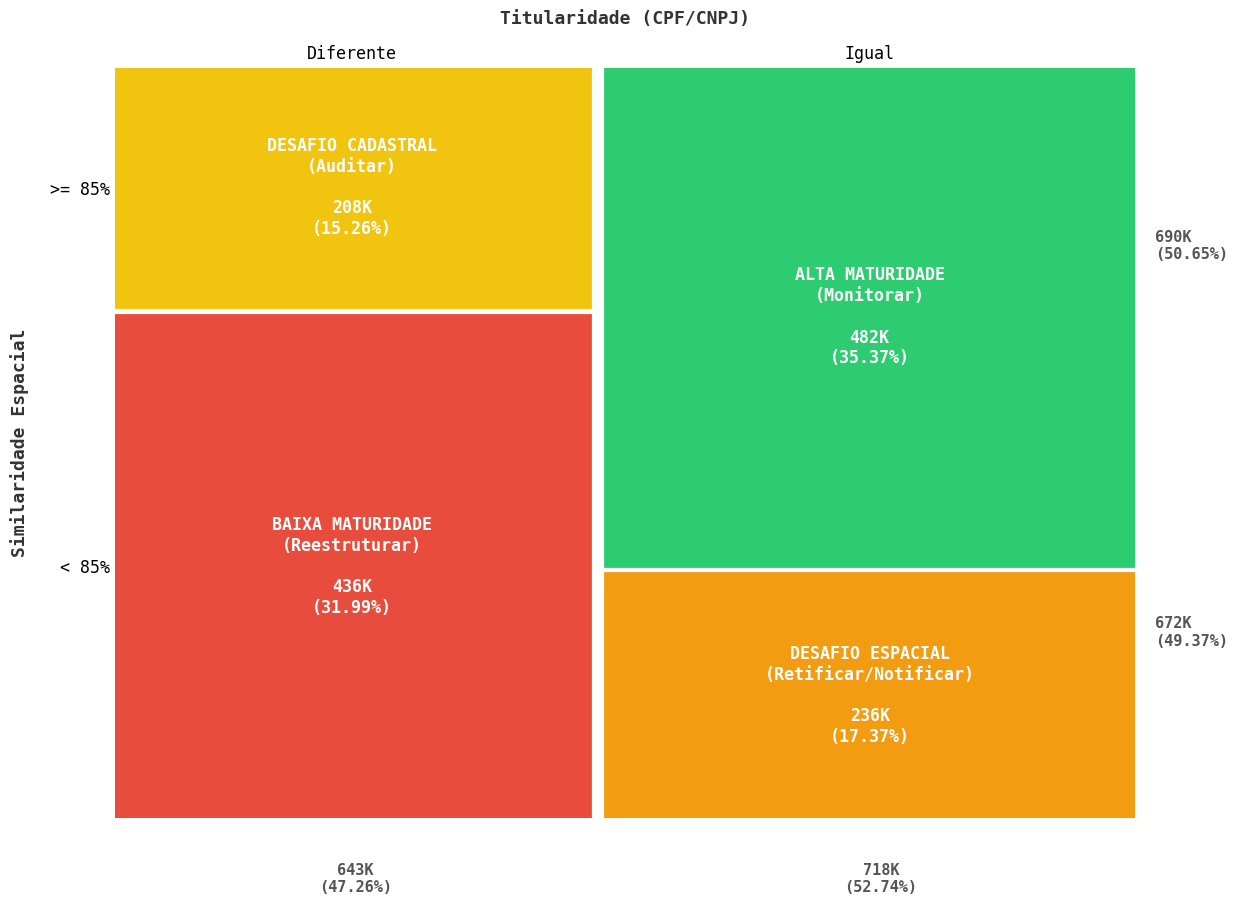

In [ ]:
data_mosaic = df.groupby(['label_cpf', 'label_geo']).size()


colors = {
    ('Igual', '>= 85%'):     '#2ecc71', # Verde
    ('Igual', '< 85%'):      '#f39c12', # Laranja
    ('Diferente', '>= 85%'): '#f1c40f', # Amarelo
    ('Diferente', '< 85%'):  '#e74c3c'  # Vermelho
}

action_labels = {
    ('Igual', '>= 85%'):     'ALTA MATURIDADE\n(Monitorar)',
    ('Igual', '< 85%'):      'DESAFIO ESPACIAL\n(Retificar/Notificar)',
    ('Diferente', '>= 85%'): 'DESAFIO CADASTRAL\n(Auditar)',
    ('Diferente', '< 85%'):  'BAIXA MATURIDADE\n(Reestruturar)'
}

def props(key):
    return {'color': colors[key], 'linewidth': 2}

total = data_mosaic.sum()

def labelizer(key):
    count = data_mosaic[key]
    perc = (count / total) * 100
    
    # Formatação do número
    if count > 1000000:
        count_str = f'{count/1000000:.2f}M'
    elif count > 1000:
        count_str = f'{count/1000:.0f}K'
    else:
        count_str = f'{count:.0f}'
        
    # Busca a frase de ação baseada na chave
    acao = action_labels.get(key, '')
    
    # Monta o texto final com quebras de linha
    # A estrutura é: AÇÃO (em cima) -> Número -> Porcentagem
    return f"{acao}\n\n{count_str}\n({perc:.2f}%)"

fig, ax = plt.subplots(figsize=(12, 10)) # Aumentei um pouco para caber o texto extra


mosaic(data_mosaic, gap=0.015, properties=props, labelizer=labelizer, ax=ax, 
       title='', horizontal=True)

# --- 4. Estilização dos Labels Internos ---
for text in ax.texts:
    text.set_color('white')
    text.set_fontsize(12)
    text.set_fontweight('bold')
    text.set_horizontalalignment('center') # Centraliza o bloco de texto

# --- 5. Ajustes de Eixos ---
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xlabel('Titularidade (CPF/CNPJ)', fontsize=13, fontweight='bold', 
              labelpad=15, color='#333333')
ax.set_ylabel('Similaridade Espacial', fontsize=13, fontweight='bold', 
              labelpad=15, color='#333333')


totais_cpf = df.groupby('label_cpf').size()
total_geral = total


col_order = ['Diferente', 'Igual'] 

pos_x = 0
for cpf_label in col_order:
    try:
        count = totais_cpf[cpf_label]
        largura = count / total_geral
        centro_x = pos_x + largura / 2
        
        perc = (count / total_geral) * 100
        count_str = f'{count/1000:.0f}K' if count > 1000 else f'{count:.0f}'
        
        ax.text(centro_x, -0.06, f'{count_str}\n({perc:.2f}%)', 
                ha='center', va='top', fontsize=11, fontweight='bold', color='#555555',
                transform=ax.transAxes)
        
        pos_x += largura + 0.015 # Adicionando o gap aproximado no calculo
    except KeyError:
        pass

# Totais por Geo (Linhas)
totais_geo = df.groupby('label_geo').size()
# Ordem visual: '< 85%' (baixo) e '>= 85%' (cima)
row_order = ['< 85%', '>= 85%']

pos_y = 0
for geo_label in row_order:
    try:
        count = totais_geo[geo_label]
        altura = count / total_geral
        centro_y = pos_y + altura / 2
        
        perc = (count / total_geral) * 100
        count_str = f'{count/1000:.0f}K' if count > 1000 else f'{count:.0f}'
        
        ax.text(1.02, centro_y, f'{count_str}\n({perc:.2f}%)', 
                ha='left', va='center', fontsize=11, fontweight='bold', color='#555555',
                transform=ax.transAxes)
        
        pos_y += altura + 0.015 # Adicionando o gap aproximado
    except KeyError:
        pass

# Limpeza final
sns.despine(left=True, bottom=True, top=True, right=True)
# Remover ticks que o mosaic as vezes deixa
ax.tick_params(axis='both', which='both', length=0)


plt.subplots_adjust(top=0.85, bottom=0.1, right=0.9, left=0.05)

plt.show()

In [ ]:
df.sample(5).to_markdown()

'|         |     id |   id_vizinhanca_sigef |   area_sigef_agregado_ha | cod_imovel                                  |   area_sicar_ha |   area_intersecao_ha |   idt_municipio | uf   | tipo_imovel   | status_imovel   | class_tam_imovel   | regiao       | bioma_desmat                    |   d2008 |   d2009 |   d2010 |   d2011 |   d2012 |   d2013 |   d2014 |   d2015 |   d2016 |   d2017 |   d2018 |   d2019 |   d2020 |   d2021 |   d2022 |   d2023 |   d2024 |   d_total | data_cadastro_imovel    |   ano_cadastro | igualdade_cpf   | faixa_jaccard   |   indice_jaccard | geo_ok   | label_cpf   | label_geo   |\n|--------:|-------:|----------------------:|-------------------------:|:--------------------------------------------|----------------:|---------------------:|----------------:|:-----|:--------------|:----------------|:-------------------|:-------------|:--------------------------------|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|----

In [ ]:
consulta = """
SELECT 
    ci.estado AS uf,
    count(*) as total
FROM regularizacao_ambiental.car_imoveis ci 
GROUP BY 
    ci.estado
"""

df_total_cars = pd.read_sql(consulta, engine)
df_total_cars.columns = ['uf', 'total_cars']

UFs com ajuste de posição: {'MG', 'RR', 'RO', 'ES', 'DF', 'RN', 'SP', 'SE', 'PR', 'RJ'}
Centralizados: 17 | Ajustados: 10


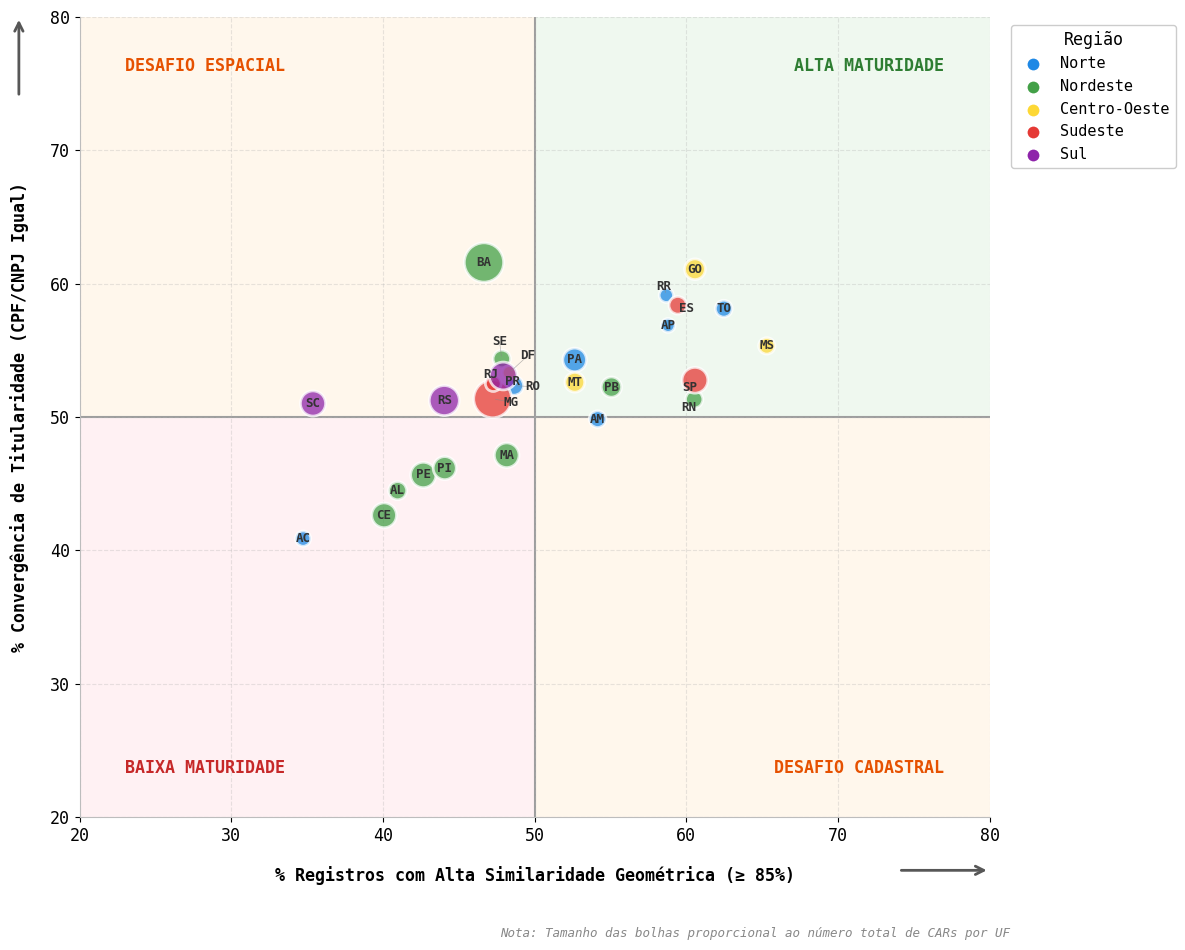

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Para evitar sobreposição de labels - instalar: pip install adjustText
from adjustText import adjust_text

# =========================================================================
# 1. PREPARANDO OS DADOS
# =========================================================================

uf_stats = df.groupby('uf').agg(
    pct_espacial_bom=('indice_jaccard', lambda x: (x >= 85).mean() * 100),
    pct_cpf_igual=('igualdade_cpf', lambda x: x.mean() * 100),
    regiao=('regiao', 'first')
).reset_index()

uf_stats = uf_stats.merge(df_total_cars[['uf', 'total_cars']], on='uf', how='left')

# =========================================================================
# 2. CONFIGURAÇÃO DO GRÁFICO - VARIÁVEIS DE CONTROLE
# =========================================================================

x_min, x_max = 20, 80
y_min, y_max = 20, 80
x_div, y_div = 50, 50

fig_width, fig_height = 14, 10

fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.add_axes([0.08, 0.1, 0.65, 0.8])

# =========================================================================
# 3. FUNDO DOS QUADRANTES
# =========================================================================

quadrant_colors = {
    'top_right': "#E8F5E9B0",
    'top_left': "#FFF3E097",
    'bottom_right': "#FFF3E097",
    'bottom_left': "#FFEBEEAE",
}

ax.add_patch(mpatches.Rectangle(
    (x_div, y_div), x_max - x_div, y_max - y_div,
    facecolor=quadrant_colors['top_right'], edgecolor='none', zorder=0
))
ax.add_patch(mpatches.Rectangle(
    (x_min, y_div), x_div - x_min, y_max - y_div,
    facecolor=quadrant_colors['top_left'], edgecolor='none', zorder=0
))
ax.add_patch(mpatches.Rectangle(
    (x_div, y_min), x_max - x_div, y_div - y_min,
    facecolor=quadrant_colors['bottom_right'], edgecolor='none', zorder=0
))
ax.add_patch(mpatches.Rectangle(
    (x_min, y_min), x_div - x_min, y_div - y_min,
    facecolor=quadrant_colors['bottom_left'], edgecolor='none', zorder=0
))

# =========================================================================
# 4. LINHAS DIVISÓRIAS
# =========================================================================

ax.axvline(x=x_div, color='#9E9E9E', linestyle='-', linewidth=1.5, zorder=1)
ax.axhline(y=y_div, color='#9E9E9E', linestyle='-', linewidth=1.5, zorder=1)

# =========================================================================
# 5. TÍTULOS DOS QUADRANTES
# =========================================================================

quadrant_titles = {
    'top_right': {'text': 'ALTA MATURIDADE', 'color': '#2E7D32'},
    'top_left': {'text': 'DESAFIO ESPACIAL', 'color': '#E65100'},
    'bottom_right': {'text': 'DESAFIO CADASTRAL', 'color': '#E65100'},
    'bottom_left': {'text': 'BAIXA MATURIDADE', 'color': '#C62828'},
}

padding = 3

ax.text(x_max - padding, y_max - padding, quadrant_titles['top_right']['text'],
        ha='right', va='top', fontsize=12, fontweight='bold', 
        color=quadrant_titles['top_right']['color'], zorder=5)
ax.text(x_min + padding, y_max - padding, quadrant_titles['top_left']['text'],
        ha='left', va='top', fontsize=12, fontweight='bold', 
        color=quadrant_titles['top_left']['color'], zorder=5)
ax.text(x_max - padding, y_min + padding, quadrant_titles['bottom_right']['text'],
        ha='right', va='bottom', fontsize=12, fontweight='bold', 
        color=quadrant_titles['bottom_right']['color'], zorder=5)
ax.text(x_min + padding, y_min + padding, quadrant_titles['bottom_left']['text'],
        ha='left', va='bottom', fontsize=12, fontweight='bold', 
        color=quadrant_titles['bottom_left']['color'], zorder=5)

# =========================================================================
# 6. SCATTER PLOT (BOLHAS) - OPÇÃO A: COM CORES POR REGIÃO
# =========================================================================

# Descomente a opção que preferir:

# --- OPÇÃO A: Colorido por região (atual) ---
palette = {
    'Norte': '#1E88E5',
    'Nordeste': '#43A047',
    'Centro-Oeste': '#FDD835',
    'Sudeste': '#E53935',
    'Sul': '#8E24AA'
}

size_min, size_max = 100, 800
sizes = uf_stats['total_cars']
sizes_normalized = ((sizes - sizes.min()) / (sizes.max() - sizes.min())) * (size_max - size_min) + size_min

for regiao in uf_stats['regiao'].unique():
    mask = uf_stats['regiao'] == regiao
    ax.scatter(
        uf_stats.loc[mask, 'pct_espacial_bom'],
        uf_stats.loc[mask, 'pct_cpf_igual'],
        s=sizes_normalized[mask],
        c=palette.get(regiao, '#999999'),
        alpha=0.75,
        edgecolors='white',
        linewidths=2,
        zorder=3
    )

# =========================================================================
# 7. LABELS DAS UFs - CENTRALIZADO QUANDO POSSÍVEL, AJUSTE SE NECESSÁRIO
# =========================================================================
from itertools import combinations

# --- ETAPA 1: IDENTIFICAR UFs PRÓXIMAS QUE PRECISAM DE AJUSTE ---
# Distância mínima entre bolhas para considerar conflito (ajuste conforme necessário)
DISTANCE_THRESHOLD = 1.5

ufs_to_adjust = set()

# Calcula distância entre todos os pares de UFs
for (idx1, row1), (idx2, row2) in combinations(uf_stats.iterrows(), 2):
    dist = np.sqrt(
        (row1['pct_espacial_bom'] - row2['pct_espacial_bom'])**2 +
        (row1['pct_cpf_igual'] - row2['pct_cpf_igual'])**2
    )
    # Se estão muito próximas, marca ambas para ajuste
    if dist < DISTANCE_THRESHOLD:
        ufs_to_adjust.add(row1['uf'])
        ufs_to_adjust.add(row2['uf'])

print(f"UFs com ajuste de posição: {ufs_to_adjust}")  # Debug (pode remover depois)

# --- ETAPA 2: CRIAR TEXTOS E SEPARAR EM DOIS GRUPOS ---
texts_to_adjust = []  # Textos que precisam do adjustText
texts_centered = []   # Textos que ficam centralizados

for idx, row in uf_stats.iterrows():
    text = ax.text(
        row['pct_espacial_bom'], 
        row['pct_cpf_igual'],
        row['uf'],
        fontsize=9,
        fontweight='bold',
        color='#333333',
        ha='center',
        va='center',
        zorder=6
    )
    
    # Separa os textos em dois grupos
    if row['uf'] in ufs_to_adjust:
        texts_to_adjust.append(text)
    else:
        texts_centered.append(text)

# --- ETAPA 3: APLICAR ADJUST_TEXT APENAS NOS PROBLEMÁTICOS ---
if texts_to_adjust:
    # Filtra as coordenadas apenas das UFs problemáticas
    mask_adjust = uf_stats['uf'].isin(ufs_to_adjust)
    x_adjust = uf_stats.loc[mask_adjust, 'pct_espacial_bom'].values
    y_adjust = uf_stats.loc[mask_adjust, 'pct_cpf_igual'].values
    
    adjust_text(
        texts_to_adjust,
        x=x_adjust,
        y=y_adjust,
        ax=ax,
        arrowprops=dict(
            arrowstyle='-',
            color='#888888',
            lw=0.5,
            alpha=0.6
        ),
        expand_points=(1.8, 1.8),
        force_points=(0.5, 0.5),
        force_text=(1.0, 1.0),
        only_move={'points': 'xy', 'texts': 'xy'}
    )

print(f"Centralizados: {len(texts_centered)} | Ajustados: {len(texts_to_adjust)}")

# =========================================================================
# 8. CONFIGURAÇÃO DOS EIXOS
# =========================================================================

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel('% Registros com Alta Similaridade Geométrica (≥ 85%)', fontsize=12, fontweight='bold', labelpad=15)
ax.set_ylabel('% Convergência de Titularidade (CPF/CNPJ Igual)', fontsize=12, fontweight='bold', labelpad=15)

tick_step = 10
ax.set_xticks(range(x_min, x_max + 1, tick_step))
ax.set_yticks(range(y_min, y_max + 1, tick_step))

ax.grid(True, linestyle='--', alpha=0.3, zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#BDBDBD')
ax.spines['bottom'].set_color('#BDBDBD')

# =========================================================================
# 9. SETAS INDICANDO "MELHOR" NOS EIXOS - FORA, MAS LIMITADO
# =========================================================================

# Seta no eixo X (direita = melhor geometria)
# Fora do gráfico (y abaixo), mas ponta limitada a x_max
ax.annotate(
    '',
    xy=(x_max, y_min - 4),           # Ponta da seta EXATAMENTE em x_max
    xytext=(x_max - 6, y_min - 4),  # Base da seta
    xycoords='data',
    textcoords='data',
    arrowprops=dict(
        arrowstyle='->',
        color="#575757",
        lw=2,
        mutation_scale=15
    ),
    annotation_clip=False
)

# Seta no eixo Y (cima = melhor titularidade)
# Fora do gráfico (x à esquerda), mas ponta limitada a y_max
ax.annotate(
    '',
    xy=(x_min - 4, y_max),           # Ponta da seta EXATAMENTE em y_max
    xytext=(x_min - 4, y_max - 6),  # Base da seta
    xycoords='data',
    textcoords='data',
    arrowprops=dict(
        arrowstyle='->',
        color="#575757",
        lw=2,
        mutation_scale=15
    ),
    annotation_clip=False
)


# =========================================================================
# 10. TÍTULO E SUBTÍTULO
# =========================================================================


# =========================================================================
# 11. LEGENDA DE REGIÕES
# =========================================================================

region_handles = [
    plt.scatter([], [], s=100, c=cor, edgecolors='white', linewidths=1.5, label=regiao)
    for regiao, cor in palette.items()
]

legend1 = fig.legend(
    handles=region_handles,
    title='Região',
    loc='upper left',
    bbox_to_anchor=(0.74, 0.90),
    frameon=True,
    fontsize=11,
    title_fontsize=12,
    framealpha=1,
    edgecolor='#CCCCCC'
)


# =========================================================================
# 13. NOTA DE RODAPÉ
# =========================================================================

fig.text(
    0.38, -0.02,
    'Nota: Tamanho das bolhas proporcional ao número total de CARs por UF',
    fontsize=9,
    color='#888888',
    style='italic'
)

# =========================================================================
# 14. MOSTRAR
# =========================================================================

plt.show()

## SNCR

In [ ]:
consulta_sncr = """
SELECT *
FROM cruzamentos.mv_resumo_cruzamento_uf        
"""

df_sncr = pd.read_sql_query(consulta_sncr, engine)
df_sncr = df_sncr.merge(uf_stats[['regiao', 'uf']], on='uf', how='left')
df_sncr

,uf,total_imoveis_car,total_imoveis_sncr,car_com_match,car_sem_match,sncr_com_match,sncr_sem_match,diff_car,diff_sncr,nivel_1_somente_cpf_cnpj,nivel_2_cpf_cnpj_municipio_area_nao_info,nivel_3_cpf_cnpj_municipio_area_fora_tol,nivel_4_match_completo,total_combinacoes,pct_car_com_match,pct_sncr_com_match,regiao
0,AC,54119,27926,12723,41396,11676,16250,0,0,5298,0,12338,12524,30160,23.51,41.81,Norte
1,AL,137471,64443,22639,114832,19124,45319,0,0,20172,0,23112,10311,53595,16.47,29.68,Nordeste
2,AM,94187,72489,18097,76090,16336,56153,0,0,11858,0,13584,10555,35997,19.21,22.54,Norte
3,AP,16113,8949,1918,14195,1676,7273,0,0,732,0,565,972,2269,11.90,18.73,Norte
4,BA,1232921,990691,349550,883371,323782,666909,0,0,626000,3,380372,179009,1185384,28.35,32.68,Nordeste
5,CE,394363,331155,129153,265210,122674,208481,0,0,21321,0,127003,79166,227490,32.75,37.04,Nordeste
6,DF,20126,12790,3782,16344,3319,9471,0,0,1593,0,3380,3049,8022,18.79,25.95,Centro-Oeste
7,ES,123696,160335,57844,65852,62124,98211,0,0,115524,0,52658,37930,206112,46.76,38.75,Sudeste
8,GO,230348,272021,125813,104535,131848,140173,0,0,101674,1,121720,88615,312010,54.62,48.47,Centro-Oeste
9,MA,390404,186039,74904,315500,76499,109540,0,0,101669,0,71525,55501,228695,19.19,41.12,Nordeste


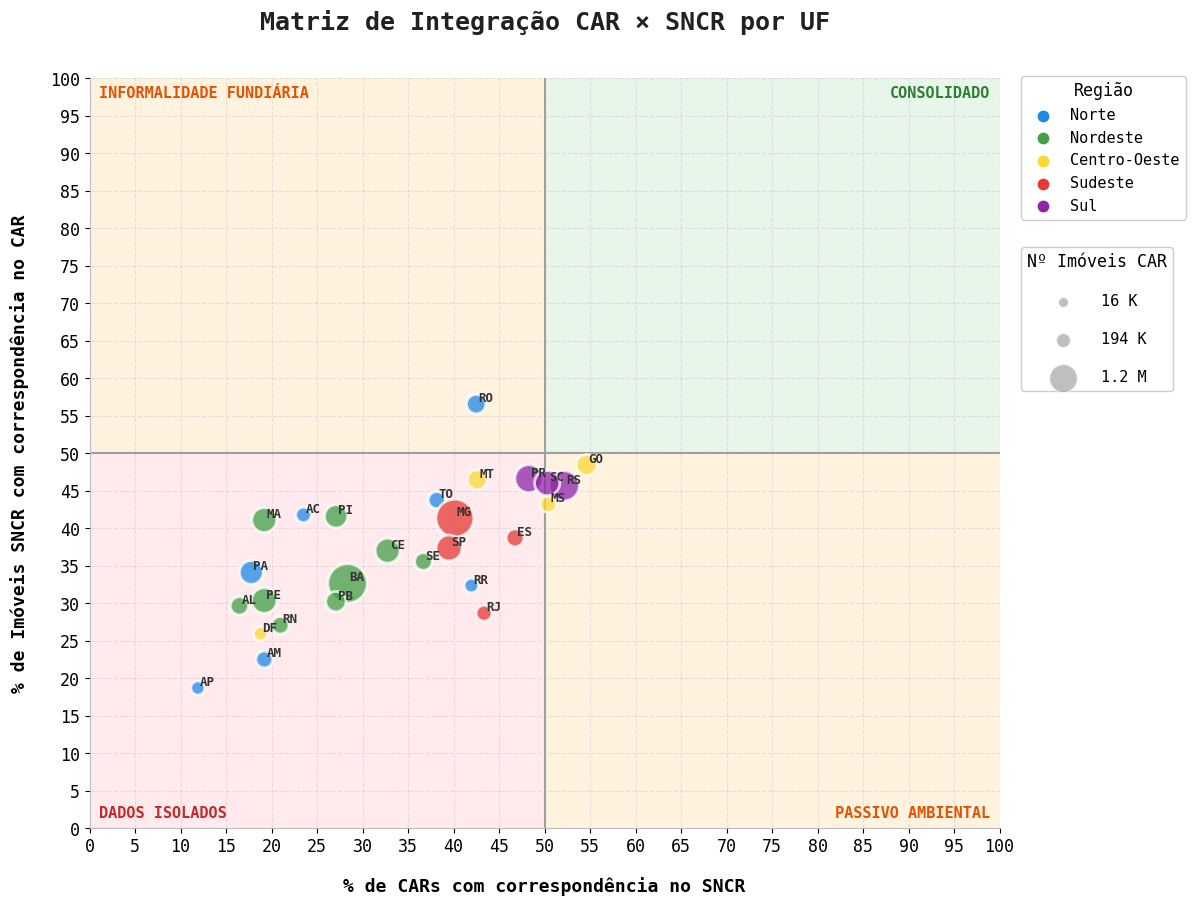

In [ ]:

# =========================================================================
# 2. CONFIGURAÇÃO DO GRÁFICO - VARIÁVEIS DE CONTROLE
# =========================================================================

x_min, x_max = 0, 100
y_min, y_max = 0, 100
x_div, y_div = 50, 50

fig_width, fig_height = 14, 10

# Criar figura e eixo com posição manual
fig = plt.figure(figsize=(fig_width, fig_height))

# Definir área do gráfico: [left, bottom, width, height] em proporção (0-1)
ax = fig.add_axes([0.08, 0.12, 0.65, 0.75])  # Ajustado para caber subtítulo e nota

# =========================================================================
# 3. FUNDO DOS QUADRANTES
# =========================================================================

quadrant_colors = {
    'top_right': '#E8F5E9',     # Verde claro - Alta integração
    'top_left': '#FFF3E0',      # Laranja claro - CAR subrepresentado
    'bottom_right': '#FFF3E0',  # Laranja claro - SNCR subrepresentado
    'bottom_left': '#FFEBEE',   # Vermelho claro - Baixa integração
}

# Superior Direito
ax.add_patch(mpatches.Rectangle(
    (x_div, y_div), x_max - x_div, y_max - y_div,
    facecolor=quadrant_colors['top_right'], edgecolor='none', zorder=0
))

# Superior Esquerdo
ax.add_patch(mpatches.Rectangle(
    (x_min, y_div), x_div - x_min, y_max - y_div,
    facecolor=quadrant_colors['top_left'], edgecolor='none', zorder=0
))

# Inferior Direito
ax.add_patch(mpatches.Rectangle(
    (x_div, y_min), x_max - x_div, y_div - y_min,
    facecolor=quadrant_colors['bottom_right'], edgecolor='none', zorder=0
))

# Inferior Esquerdo
ax.add_patch(mpatches.Rectangle(
    (x_min, y_min), x_div - x_min, y_div - y_min,
    facecolor=quadrant_colors['bottom_left'], edgecolor='none', zorder=0
))

# =========================================================================
# 4. LINHAS DIVISÓRIAS
# =========================================================================

ax.axvline(x=x_div, color='#9E9E9E', linestyle='-', linewidth=1.5, zorder=1)
ax.axhline(y=y_div, color='#9E9E9E', linestyle='-', linewidth=1.5, zorder=1)

# =========================================================================
# 5. TÍTULOS DOS QUADRANTES
# =========================================================================

quadrant_titles = {
    'top_right': {
        'text': 'CONSOLIDADO', 
        'color': '#2E7D32'
    },
    'top_left': {
        'text': 'INFORMALIDADE FUNDIÁRIA', 
        'color': '#E65100'
    },
    'bottom_right': {
        'text': 'PASSIVO AMBIENTAL', 
        'color': '#E65100'
    },
    'bottom_left': {
        'text': 'DADOS ISOLADOS', 
        'color': '#C62828'
    },
}

padding = 1

ax.text(x_max - padding, y_max - padding, quadrant_titles['top_right']['text'],
        ha='right', va='top', fontsize=11, fontweight='bold', 
        color=quadrant_titles['top_right']['color'], zorder=5)

ax.text(x_min + padding, y_max - padding, quadrant_titles['top_left']['text'],
        ha='left', va='top', fontsize=11, fontweight='bold', 
        color=quadrant_titles['top_left']['color'], zorder=5)

ax.text(x_max - padding, y_min + padding, quadrant_titles['bottom_right']['text'],
        ha='right', va='bottom', fontsize=11, fontweight='bold', 
        color=quadrant_titles['bottom_right']['color'], zorder=5)

ax.text(x_min + padding, y_min + padding, quadrant_titles['bottom_left']['text'],
        ha='left', va='bottom', fontsize=11, fontweight='bold', 
        color=quadrant_titles['bottom_left']['color'], zorder=5)

# =========================================================================
# 6. SCATTER PLOT (BOLHAS)
# =========================================================================

palette = {
    'Norte': '#1E88E5',
    'Nordeste': '#43A047',
    'Centro-Oeste': '#FDD835',
    'Sudeste': '#E53935',
    'Sul': '#8E24AA'
}

size_min, size_max = 100, 800
sizes = df_sncr['total_imoveis_car']
sizes_normalized = ((sizes - sizes.min()) / (sizes.max() - sizes.min())) * (size_max - size_min) + size_min

for regiao in df_sncr['regiao'].unique():
    mask = df_sncr['regiao'] == regiao
    ax.scatter(
        df_sncr.loc[mask, 'pct_car_com_match'],
        df_sncr.loc[mask, 'pct_sncr_com_match'],
        s=sizes_normalized[mask],
        c=palette.get(regiao, '#999999'),
        alpha=0.75,
        edgecolors='white',
        linewidths=2,
        zorder=3
    )

# =========================================================================
# 7. LABELS DAS UFs
# =========================================================================

for idx, row in df_sncr.iterrows():
    x_offset = 1.5
    y_offset = 1.5
    ha = 'left'
    
    # Ajustar posição se estiver perto da borda direita
    if row['pct_car_com_match'] > (x_max - 5):
        ha = 'right'
        x_offset = -1.5
    
    ax.annotate(
        row['uf'],
        (row['pct_car_com_match'], row['pct_sncr_com_match']),
        xytext=(x_offset, y_offset),
        textcoords='offset points',
        fontsize=9,
        fontweight='bold',
        color='#333333',
        zorder=4
    )

# =========================================================================
# 8. CONFIGURAÇÃO DOS EIXOS
# =========================================================================

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.set_xlabel(
    '% de CARs com correspondência no SNCR', 
    fontsize=13, 
    fontweight='bold', 
    labelpad=15
)
ax.set_ylabel(
    '% de Imóveis SNCR com correspondência no CAR', 
    fontsize=13, 
    fontweight='bold', 
    labelpad=15
)

tick_step = 5
ax.set_xticks(range(x_min, x_max + 1, tick_step))
ax.set_yticks(range(y_min, y_max + 1, tick_step))

ax.grid(True, linestyle='--', alpha=0.3, zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#BDBDBD')
ax.spines['bottom'].set_color('#BDBDBD')

# =========================================================================
# 9. TÍTULO E SUBTÍTULO
# =========================================================================

ax.set_title(
    'Matriz de Integração CAR × SNCR por UF',
    fontsize=18,
    fontweight='bold',
    color='#212121',
    pad=35
)


# =========================================================================
# 10. LEGENDA DE REGIÕES
# =========================================================================

region_handles = [
    plt.scatter([], [], s=100, c=cor, edgecolors='white', linewidths=1.5, label=regiao)
    for regiao, cor in palette.items()
]

legend1 = fig.legend(
    handles=region_handles,
    title='Região',
    loc='upper left',
    bbox_to_anchor=(0.74, 0.88),
    frameon=True,
    fontsize=11,
    title_fontsize=12,
    framealpha=1,
    edgecolor='#CCCCCC'
)

# =========================================================================
# 11. LEGENDA DE TAMANHO
# =========================================================================

size_legend_values = [
    int(df_sncr['total_imoveis_car'].min()),
    int(df_sncr['total_imoveis_car'].quantile(0.5)),
    int(df_sncr['total_imoveis_car'].max())
]

size_handles = []
for val in size_legend_values:
    size_norm = ((val - sizes.min()) / (sizes.max() - sizes.min())) * (size_max - size_min) + size_min
    size_handles.append(
        plt.scatter([], [], s=size_norm * 0.5, c='gray', alpha=0.5, edgecolors='white', linewidths=1)
    )

def format_number(n):
    if n >= 1_000_000:
        return f'{n/1_000_000:.1f} M'
    elif n >= 1_000:
        return f'{n/1_000:.0f} K'
    return str(n)

legend2 = fig.legend(
    handles=size_handles,
    labels=[format_number(v) for v in size_legend_values],
    title='Nº Imóveis CAR',
    loc='lower left',
    bbox_to_anchor=(0.74, 0.55),
    frameon=True,
    fontsize=11,
    title_fontsize=12,
    labelspacing=1.5,
    handletextpad=1.5,
    framealpha=1,
    edgecolor='#CCCCCC'
)

# =========================================================================
# 13. MOSTRAR
# =========================================================================

plt.show()